<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Exercises/14_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook pre steps

In [1]:
#@title Installations

# install missing packages
!pip install -q dfply
import plotly.io as pio
pio.renderers.default = "colab"

from dfply import *
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import math
import random
from IPython.display import display, Markdown
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.9 MB/s eta 0:00:00


# Policy Gradient Methods

Here, we focus on directly learning a parameterized policy that can select actions without referring to a value function.

Let the policy be represented as $$\pi(a|s, \theta) = \Pr(A_t = a|S_t = s, \theta_t = \theta),$$ where $\theta \in \mathbb{R}^{d'}$ is a vector of policy parameters. That is, $\pi(a|s, \theta)$ is the probability that action $a$ is taken in state $s$ when the policy parameters have value $\theta$.

The objective is to learn the policy parameters by following the gradient of a scalar performance measure $J(\theta)$ with respect to $\theta$. The goal is to maximize performance, the parameter updates follow a stochastic gradient-ascent rule:
$$
\theta_{t+1} = \theta_t + \alpha \nabla J(\theta_t)
$$
where $\nabla J(\theta_t)$ is an estimate of the gradient of the performance measure with respect to $\theta_t$.

First, we consider the episodic setting, where performance is defined as the value of the start state under the parameterised policy. Next, the continuing case is considered, where performance is defined in terms of the long-run average reward.


## Seasonal inventory and sales planning

In the episodic setting, we address the seasonal inventory and sales planning problem in [Example 9.4.4](https://bss-osca.github.io/rl/09_mc.html#sec-mc-seasonal).

We consider seasonal products such as garden furniture. Assume that the maximum inventory level is $Q$ items, meaning we can purchase at most $Q$ items at the start of the season for a fixed price. The product can be sold for up to $T$ weeks, and at the end of the period (week $T$), any remaining inventory is sold to an outlet store at scrap price.

Let $s = (q,t)$ denote the state of the system at the start of a week. There is a terminal state when the inventory is empty. Actions involve choosing a price, and for now, we limit ourselves to the set $\{10, 15, 20, 25\}$.

Our objective is to maximize the total discounted reward, given we start in state $(65,1)$, i.e $J(\theta) = v_{\pi_\theta}((65,1))$.

First, we load the optimal policy for comparison. Assuming the starting state is $(65,1)$, we find optimal objective function value $J(\theta) = v_\pi(s_0) = v_\pi((65,1))$:

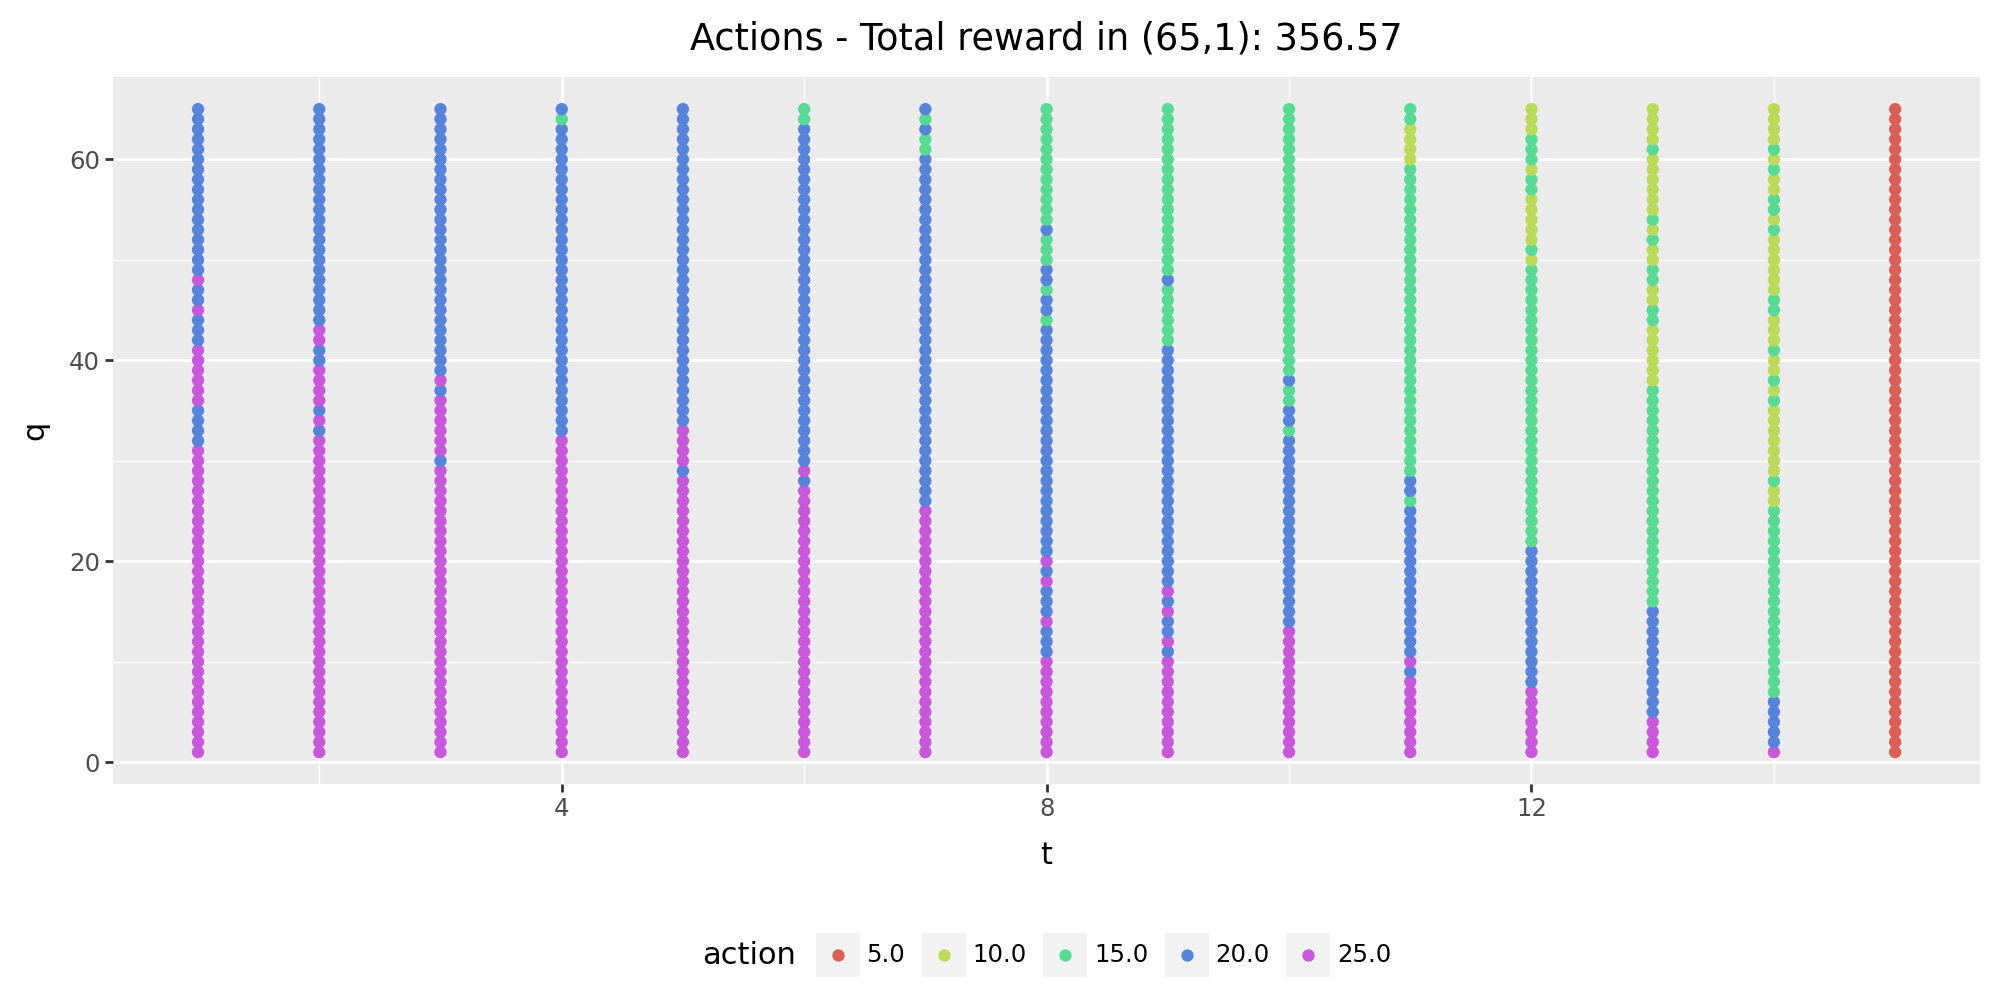

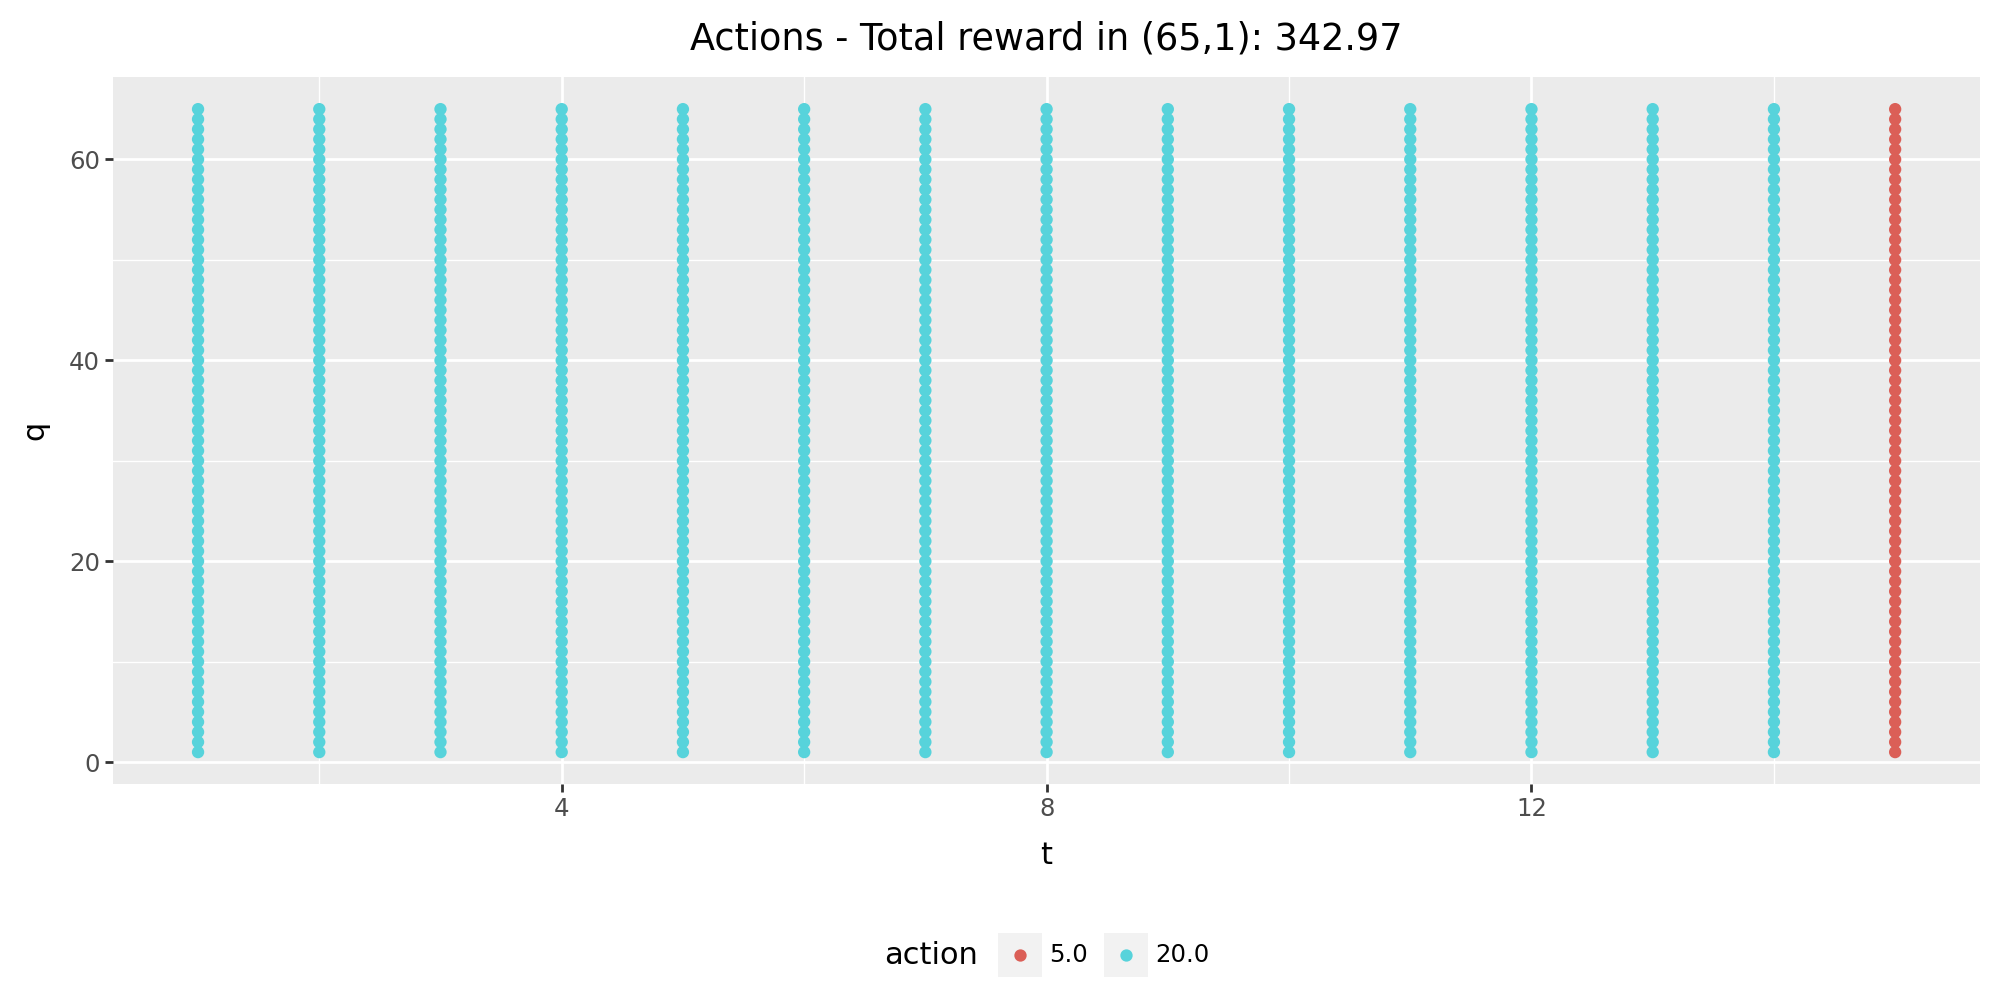

In [2]:
#@title MDP solution

start_q = 65  # start inventory
dat_mdp = pd.read_csv('https://drive.google.com/uc?id=1dY6r4xKFwIv3DBEHiOnehbiVEGAhqQax', index_col = False)
dat_mdp = dat_mdp >> mask(X.q <= start_q)

# Plot optimal policy
v_opt = dat_mdp >> mask(X.q == start_q, X.t == 1)
v_opt = float(v_opt['v'].values[0].round(2))  # Optimal value
dat_a = dat_mdp
dat_a['action'] = pd.Categorical(dat_a['action'])
pt = (
    ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
    + geom_point()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(title = f"Actions - Total reward in (65,1): {v_opt}")
)
pt.show()


# Plot - Policy to use 20 as price always
dat_mdp20 = pd.read_csv('https://drive.google.com/uc?id=1OZI6Ic-08X7RUx656Sg9v_wJ3rvV-xbe', index_col = False)
dat_mdp20 = dat_mdp20 >> mask(X.q <= start_q)
v = dat_mdp20 >> mask(X.q == start_q, X.t == 1)
v = float(v['v'].values[0].round(2))
dat_a = dat_mdp20
dat_a['action'] = pd.Categorical(dat_a['action'])
pt = (
    ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
    + geom_point()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(title = f"Actions - Total reward in (65,1): {v}")
)
pt.show()

Note we have also loaded the policy to use a price equal to 20 always, which has $v_\pi((65,1))$ close to the optimal value.

The inventory dynamics and rewards are coded in the environment below:

In [3]:
#@title RL environment - Seasonal

from __future__ import annotations  # forward refs

import numpy as np
import pandas as pd


class RLEnvSeasonal:
    """
    Seasonal single-item pricing/sales environment.

    State space:
      - non-terminal states are strings "q,t" where q∈{1..max_inv}, t∈{1..max_t}
      - terminal state is `None`

    Action space:
      - at t < max_t: choose a price from self.prices (as string)
      - at t == max_t: action is effectively a dummy (we scrap remaining inventory)

    Stochastic demand depends on price via a piecewise curve and has early-season uplift.
    """

    def __init__(self,
                 max_inv: int,
                 max_t: int,
                 scrap_price: float,
                 purchase_price: float,
                 prices: list[float],
                 start_q = None,
                 seed = None) -> None:

        """
        Initializes the seasonal RL environment.

        Args:
            max_inv: Maximum inventory units.
            max_t: Number of selling weeks.
            scrap_price: Value per leftover at final week.
            purchase_price: Unit purchase cost at t=1.
            prices: Allowable sale prices.
            start_q: Initial inventory level used.
            seed: Seed for random number generator.
        """
        self.max_inv = int(max_inv)
        self.max_t = int(max_t)
        self.scrap_price = float(scrap_price)
        self.purchase_price = float(purchase_price)
        self.prices = list(map(float, prices))
        self.rng = np.random.default_rng(seed)
        self.rng_seed = seed
        self.start_q = start_q

    def reset(self, q = None) -> list[int]:
        """
        Reset the environment to the initial state.

        Returns:
            The initial state.
        """
        t = 1  # start at time 1
        if self.start_q:
            return(int(self.start_q), t)
        if not q:
            q = self.rng.integers(1, self.max_inv + 1)
        return [int(q), t]

    def reset_rng(self):
        """
        Reset the random number generator.

        Returns:
            The initial state.
        """
        self.rng = np.random.default_rng(self.rng_seed)
        return self.reset()

    # ----------------------------- state & action spaces ----------------------

    def get_states(self) -> list[str]:
        """
        Return all states.
        """
        states = [(q,t) for q in range(1, self.max_inv + 1) for t in range(1, self.max_t + 1)]
        return states

    def get_actions(self, s) -> list[float]:
        """
        Return available actions for state s.

        Args:
            s: The state.

        Returns:
            A list of actions for the given state.
        """
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(t)
        assert 1 <= t <= self.max_t
        if t == self.max_t:
            return [self.scrap_price]
        assert np.isscalar(q)
        assert 1 <= q <= self.max_inv
        return self.prices

    def get_nb_states(self) -> int:
        """
        Return the number of states.

        Returns:
            The number of states.
        """
        return self.max_inv * self.max_t

    def get_nb_actions(self) -> int:
        """
        Return the number of actions.

        Returns:
            The number of actions.
        """
        return len(self.prices+1)

    # ----------------------------- demand model --------------------------------

    def get_demand(self, price: float, t: int) -> int:
        """
        Sample a stochastic demand for a given price and week.

        Piecewise base demand:
          - linear between (10,20) and (12,12)
          - linear between (12,12) and (15,10)
          - log tail beyond 15
        Early-season uplift for t <= max_t/2.

        Args:
            price: The price.
            t: The week.

        Returns:
            The sampled demand as an integer.
        """
        # l1: between price 10..12
        # l2: between price 12..15
        # l3: beyond 15, log decay anchored at (15,10)
        if price <= 12.0:
            a = (20.0 - 12.0) / (10.0 - 12.0)
            b = 20.0 - a * 10.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        elif 12.0 <= price <= 15.0:
            a = (12.0 - 10.0) / (12.0 - 15.0)
            b = 12.0 - a * 12.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        else:
            d = -4.0 * np.log(price - 15.0 + 1.0) + 10.0
            d_s = d * self.rng.uniform(1.0, 2.0)
        if t <= self.max_t / 2.0:
            d_s *= self.rng.uniform(1.0, 1.2)
        return int(round(max(0.0, d_s)))

    # ----------------------------- single-step API for RLAgent -----------------

    def get_step(self, s, a: float) -> tuple[list[int] | None, float, bool]:
        """
        One simulated step: given (s,a) -> (s_n, a_n, terminal)

        Args:
            s: The current state (list).
            a: The action taken (scalar).

        Returns:
            The next state, reward, and terminal flag.
        """
        assert np.isscalar(a)
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(q)
        assert np.isscalar(t)
        if q == 0:
            return (None, 0.0, True)
        if t == self.max_t:
            r = self.scrap_price * q
            return (None, r, True)
        price = float(a)
        d = self.get_demand(price, t)
        sold = min(q, d)
        r = price * sold
        if t == 1:
            r -= q * self.purchase_price
        q_n = q - sold
        if q_n == 0:
            return (None, r, True)
        return ([q_n, t+1], r, False)

Let us create an instance of the environment:

In [4]:
# Define candidate sales prices
prices = [10, 15, 20, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=100,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

### Your turn

What is the effect of argument `start_q`? Is there any reason to set `max_inv = 100`?

*Your comments*

## Policy Approximation Class

This `SoftmaxPolicy` class implements a softmax policy for discrete action spaces, where action preferences are a linear function of state-action features. This is a common approach for policy gradient methods like REINFORCE when function approximation is needed.

In [5]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicy:
    """Softmax policy with a separate parameter vector for each action.

    Each action a has its own weight vector θ_a. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the state feature vector is:

        x(s) = [1.0, q / max_inv, t / max_t].

    This formulation supports state-dependent action sets, including a
    terminal scrap action.
    """

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
    ) -> None:
        """Initializes the softmax policy.

        Args:
            env: Environment providing attributes `max_inv`, `max_t`,
                `prices`, `scrap_price`, and a method `get_actions(s)`.
            step_size: Initial learning rate alpha.
            decay_fct: Multiplicative decay applied to alpha after each
                update. Defaults to 1.0 (no decay).
            rng_seed: Optional random seed.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Explicit action → index mapping
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # State feature count: [1, q/max_inv, t/max_t]
        self.num_features = 3

        # Parameter matrix: one θ-vector per action
        self.theta = np.zeros(
            (self.num_actions, self.num_features),
            dtype=float,
        )

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Computes a numerically stable softmax.

        Args:
            x: Input score vector.

        Returns:
            Softmax probabilities over the input.
        """
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Constructs the state feature vector.

        Args:
            s: State [q, t].

        Returns:
            Feature vector x(s).
        """
        q, t = s
        return np.array(
            [1.0, q / self.max_inv, t / self.max_t],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Computes the preference values h(s, a) for available actions.

        Args:
            s: State [q, t].

        Returns:
            A vector of preferences for actions available in s.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)

        # Convert actions to their global parameter indices
        idxs = [self.act2idx[a] for a in actions]

        return np.array([self.theta[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Computes the policy distribution π(. | s).

        Args:
            s: State [q, t].

        Returns:
            Action probabilities for actions available in s.
        """
        prefs = self.get_action_preferences(s)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from the policy.

        Args:
            s: State [q, t].

        Returns:
            Sampled action from π(. | s).
        """
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns the action with the highest preference h(s, a).

        Args:
            s: State [q, t].

        Returns:
            The best action according to current θ.
        """
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇θ log π(a | s).

        The gradient has the same shape as θ. For softmax:

            ∇θ_a log π(a | s)     = (1 − π(a | s)) · x(s)
            ∇θ_b log π(a | s)     = −π(b | s) · x(s),  b ≠ a

        Args:
            s: State [q, t].
            a: Chosen action.

        Returns:
            Gradient matrix matching shape of θ.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        # Identify chosen action coordinate
        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        # Fill gradient rows
        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """Applies a REINFORCE parameter update.

        Update rule:
            θ ← θ + α * mult * ∇θ log π(a | s)

        Args:
            s: State at time t.
            a: Action taken at time t.
            mult: Scalar multiplier, typically (γ^t) G_t.
        """
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


Note that class `SoftmaxPolicy` we implement methods for calculating action probabilities, action selection, linear features for the preferences $h(s,a,\theta)$, finding the gradient, training etc.

**Calculating the gradient**

Note that since $\theta$ is a matrix ($|A| × 3$) the eligibility vector $\nabla_\theta \ln \pi(a \mid s;\theta)$ is also a matrix (or think of it as a vector where each entry is $\theta_a = (\theta_{1,a}, \theta_{2,a}, \theta_{3,a})$.

First observe that
$$
\begin{align}
\ln \pi(a \mid s;\theta) &= \ln \exp\big(\theta^\top x(s,a)\big) - \ln \sum_b \exp\big(\theta^\top x(s,b)\big) \\
   &= \theta^\top x(s,a) - \ln \sum_b \exp\big(\theta^\top x(s,b)\big)
 \end{align}
$$
If we consider the a'th row in $\nabla_\theta \ln \pi(a \mid s;\theta)$ then
$$
\begin{align}
\nabla_{\theta_a} \ln \pi(a \mid s;\theta) &=
x(s) - \pi(a \mid s;\theta)x(s,a) \\
 &= (1-\pi(a \mid s;\theta))x(s,a).
\end{align}
$$
since $\nabla_{\theta_a} x(s,b) = 0$ if $b\neq a$. If we consider the b'th row, $b\neq a$, in $\nabla_\theta \ln \pi(a \mid s;\theta)$ then
$$
\begin{align}
\nabla_{\theta_b} \ln \pi(a \mid s;\theta) &=
- \pi(b \mid s;\theta)x(s,b)
\end{align}
$$
Putting it together, we have the rows in the matrix is
$$
(\nabla_{\theta} \ln \pi(a \mid s;\theta))_a =
\begin{cases}
  (1 - \pi(a \mid s;\theta)) x(s) & \text{row for action $a$} \\
  - \pi(b \mid s;\theta)x(s) & \text{other rows}
\end{cases}
$$





### Your turn

What linear features are used here and how many?

*Your comments*



Let us create an instance of the policy:

In [ ]:
pi_hat = SoftmaxPolicy(
    env,
    step_size=0.1,
    rng_seed=42 # for reproducibility
)

# Test 1
print(f"Initial policy parameters (theta): {pi_hat.theta}")
s = env.reset()
print(f"Current state: {s}")
env_actions = env.get_actions(s)
print(f"Allowed actions in current state: {env_actions}")
probs = pi_hat.get_probabilities(s)
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
print(f"Action probabilities: {dict(zip(env_actions, probs.tolist()))}")
selected_action = pi_hat.get_action(s)
print(f"Selected action: {selected_action}")
x = pi_hat.get_state_features(s)
print(f"State feature vector: {x.round(2)}")
grad = pi_hat.get_log_gradient(s, selected_action)
print(f"Log-probability gradient for selected action: {grad}")
pi_hat.train(s, selected_action, mult = 250)
print(f"Updated policy parameters (theta) after a simulated update: {pi_hat.theta}")
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
probs_after_update = pi_hat.get_probabilities(s)
print(f"Action probabilities after update: {dict(zip(env_actions, probs_after_update.tolist()))}")

# Test 2
pi_hat.reset()
print(f"\nInitial policy parameters (theta): {pi_hat.theta}")
s = [3,15]
print(f"Current state: {s}")
env_actions = env.get_actions(s)
print(f"Allowed actions in current state: {env_actions}")
probs = pi_hat.get_probabilities(s)
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
print(f"Action probabilities: {dict(zip(env_actions, probs.tolist()))}")
selected_action = pi_hat.get_action(s)
print(f"Selected action: {selected_action}")
x = pi_hat.get_state_features(s)
print(f"Feature vector for selected action: {x.round(2)}")
grad = pi_hat.get_log_gradient(s, selected_action)
print(f"Log-probability gradient for selected action: {grad}")
pi_hat.train(s, selected_action, mult = 5)
print(f"Updated policy parameters (theta) after a simulated update: {pi_hat.theta}")
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
probs_after_update = pi_hat.get_probabilities(s)
print(f"Action probabilities after update: {dict(zip(env_actions, probs_after_update.tolist()))}")

Initial policy parameters (theta): [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Current state: (65, 1)
Allowed actions in current state: [10.0, 15.0, 20.0, 25.0]
Action preferences: [0. 0. 0. 0.]
Action probabilities: {10.0: 0.25, 15.0: 0.25, 20.0: 0.25, 25.0: 0.25}
Selected action: 25.0
State feature vector: [1.   0.65 0.07]
Log-probability gradient for selected action: [[-0.25       -0.1625     -0.01666667]
 [-0.25       -0.1625     -0.01666667]
 [-0.25       -0.1625     -0.01666667]
 [ 0.75        0.4875      0.05      ]
 [ 0.          0.          0.        ]]
Updated policy parameters (theta) after a simulated update: [[-6.25       -4.0625     -0.41666667]
 [-6.25       -4.0625     -0.41666667]
 [-6.25       -4.0625     -0.41666667]
 [18.75       12.1875      1.25      ]
 [ 0.          0.          0.        ]]
Action preferences: [-8.91840278 -8.91840278 -8.91840278 26.75520833]
Action probabilities after update: {10.0: 3.2147525159453605e-16, 15.0: 3.21475251594536

### Your turn

Explain the output.

*Your comments*

## REINFORCE

We are now ready to implement REINFORCE

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1303_REINFORCE.png)

In [ ]:
#@title REINFORCE algorithm

def reinforce(
    pi_hat: SoftmaxPolicy,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Runs the REINFORCE algorithm with a given policy.

    This uses the episodic, discounted REINFORCE algorithm as in Sutton &
    Barto (2nd ed.), with the update:

        θ ← θ + α * (γ^t) * G_t * ∇θ log π(A_t | S_t; θ),

    where G_t is the discounted return from time t.

    Args:
        pi_hat: Policy object implementing get_action() and train().
        episodes: Number of episodes to run.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
            Signature: callback(pi_hat, info, trace).
        callback_every: Frequency of callback in episodes. If 0, callback
            is never called.
        trace: Optional object passed through to callback (e.g., list or
            dict for logging).
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generates one episode using the current policy.

        Args:
            policy: Policy used to generate actions.

        Returns:
            A list of (s, a, r) tuples for one episode.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0

    for ep in tqdm(range(1, episodes + 1)):
        trajectory = generate_episode(pi_hat)

        # Compute returns G_t backward and update policy
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t
            mult = (gamma ** t) * G_t
            pi_hat.train(s_t, a_t, mult)

        # At the end of the backward pass, G_t is the return from t=0
        episode_return = G_t
        total_return += episode_return
        total_return_every = total_return_every + episode_return

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)

### Your turn

Explain the info stored and pushed to the callback function.

*Your comments*

100%|██████████| 10000/10000 [00:33<00:00, 299.29it/s]


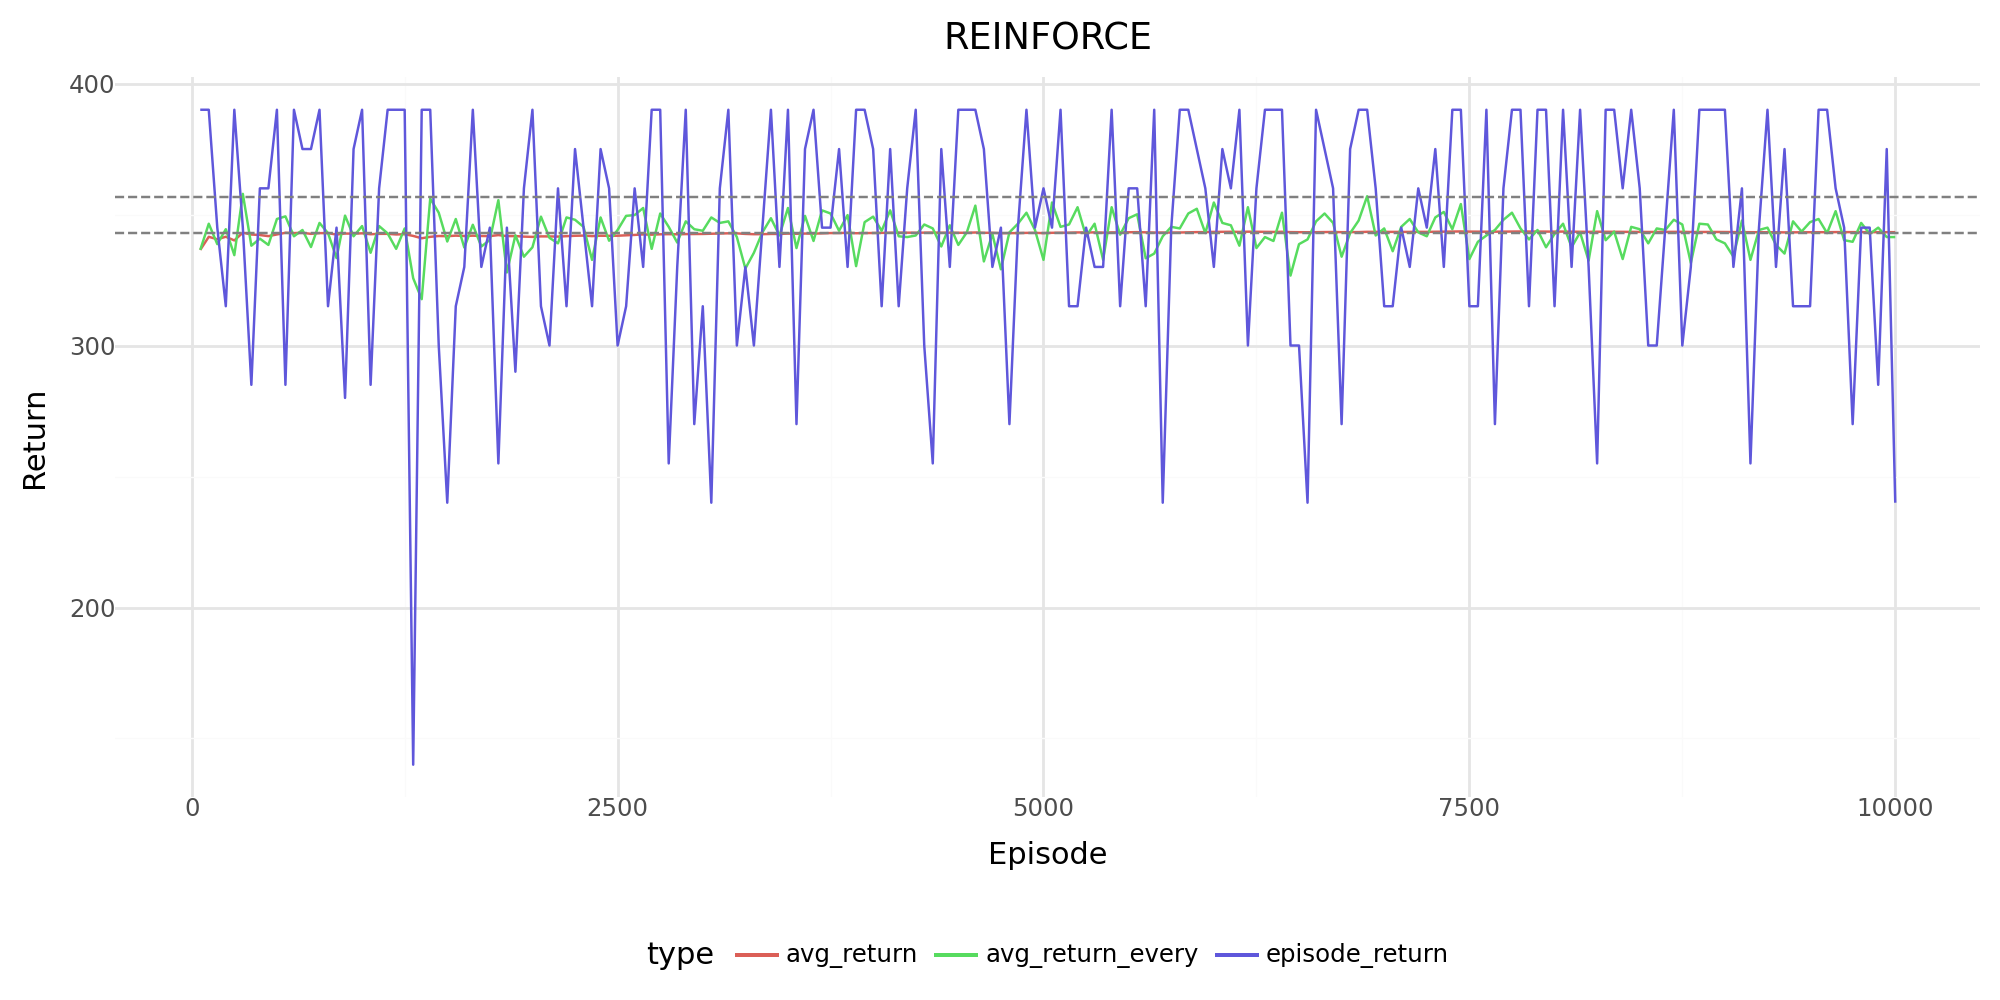

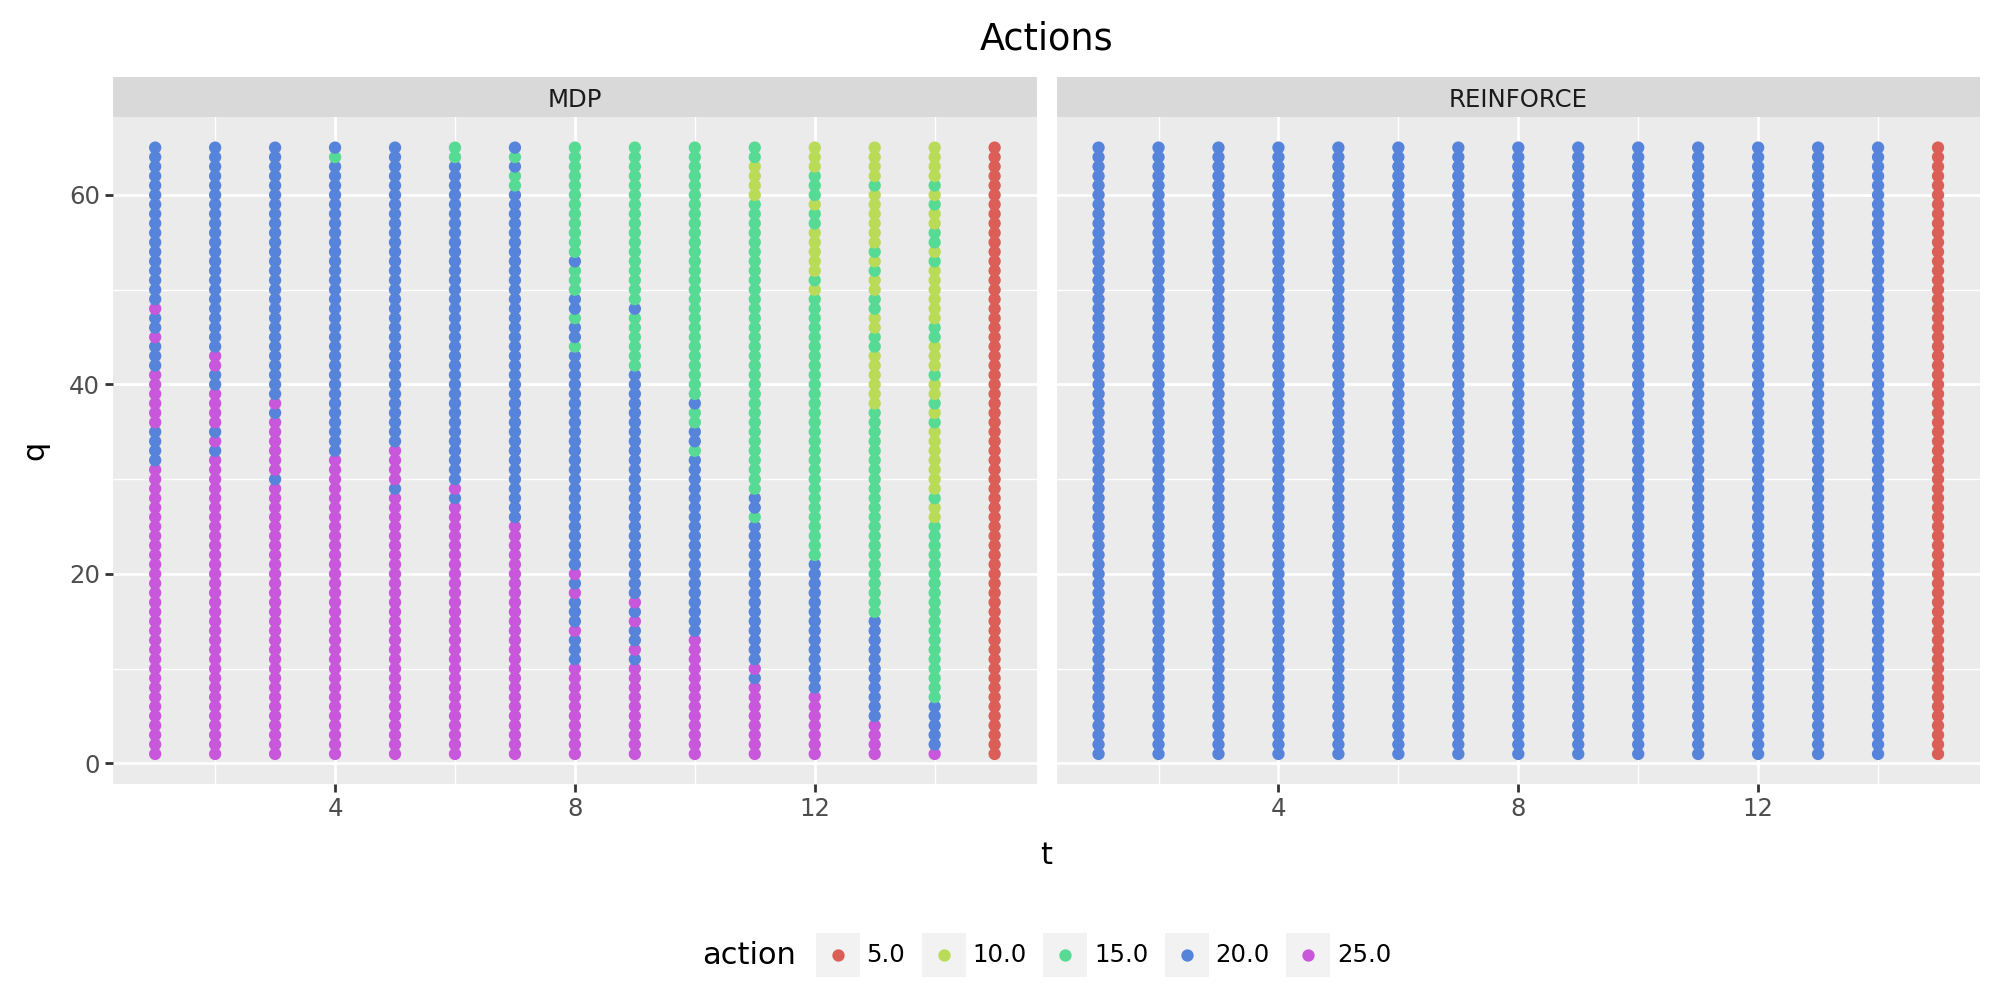

Theta: [[-2.04 -1.9  -0.33]
 [-2.19 -1.33 -0.75]
 [ 6.56  5.32  1.7 ]
 [-2.33 -2.09 -0.62]
 [ 0.    0.    0.  ]]
A few probability distributions:
State [65, 1]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-3.963
  price= 15.0, π(a|s)= 0.000 h(s,a)=-3.572
  price= 20.0, π(a|s)= 1.000 h(s,a)=11.995
  price= 25.0, π(a|s)= 0.000 h(s,a)=-4.461

State [1, 1]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-2.091
  price= 15.0, π(a|s)= 0.000 h(s,a)=-2.262
  price= 20.0, π(a|s)= 1.000 h(s,a)= 6.756
  price= 25.0, π(a|s)= 0.000 h(s,a)=-2.403

State [1, 14]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-2.378
  price= 15.0, π(a|s)= 0.000 h(s,a)=-2.909
  price= 20.0, π(a|s)= 1.000 h(s,a)= 8.228
  price= 25.0, π(a|s)= 0.000 h(s,a)=-2.941

State [65, 14]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-4.249
  price= 15.0, π(a|s)= 0.000 h(s,a)=-4.219
  price= 20.0, π(a|s)= 1.000 h(s,a)=13.468
  price= 25.0, π(a|s)= 0.000 h(s,a)=-4.999

State [2, 15]:
  price=  5.0, π(a|s)= 1.000 h(s,a)= 0.000



In [ ]:
# Define candidate sales prices
prices = [10, 15, 20, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=2e-3,  #1e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# Callback: store episode & avg return
def callback(pi_hat, info, trace):
    trace.append(info)

# Run REINFORCE
gamma = 1
episodes = 10000
trace_re = []   # will hold dicts: {episode, avg_return}
reinforce(
    pi_hat=pi_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re
)

# Plot trace
def plot_results(pi_hat, trace, dat_mdp, title_r = "", print_dist = False, plot_policy = True, plot_hlines = True, plot_mdp = True):
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "return" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("episode", "r", color = "type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Episode",
            y="Return",
        )
    )
    if plot_hlines:
        pt = (
            pt
            + geom_hline(yintercept=v_opt, linetype="dashed", color="grey")
            + geom_hline(yintercept=v, linetype="dashed", color="grey")
        )
    pt.show()

    if plot_policy:
        dat_a = pd.DataFrame({'s': pi_hat.env.get_states()})
        dat_a = (
            dat_a
            >> mutate(
                q = X.s.apply(lambda s: s[0]),
                t = X.s.apply(lambda s: s[1]),
                action = [pi_hat.get_best_action(s) for s in dat_a['s']],
                alg = title_r
            )
            >> select(~X.s)
        )
        if plot_mdp:
            dat_a = dat_a >> bind_rows(dat_mdp >> select(~X.v) >> mutate(alg = "MDP"))
        dat_a['action'] = pd.Categorical(dat_a['action'])
        pt = (
            ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
            + geom_point()
            + theme(figure_size=(10, 5), legend_position='bottom')
            + labs(title = "Actions")
        )
        if plot_mdp:
            pt = pt + facet_grid(cols="alg")
        pt.show()
    if print_dist:
        print(f"Theta: {pi_hat.theta.round(2)}")
        print("A few probability distributions:")
        test_states = [[65, 1], [1, 1], [1, 14], [65, 14], [2, 15]]
        for s in test_states:
            actions = pi_hat.env.get_actions(s)
            prefs = pi_hat.get_action_preferences(s)
            probs = pi_hat.get_probabilities(s)
            print(f"State {s}:")
            for a, p, pf in zip(actions, probs, prefs):
                print(f"  price={a:5.1f}, π(a|s)={p:6.3f} h(s,a)={pf:6.3f}")
            print()

plot_results(pi_hat, trace_re, dat_mdp, title_r = "REINFORCE", print_dist = True)

### Your turn

Explain the output.

*Your comments*

The step-size may affect the algorithm much and also the starting seed of the environment.


=== Testing step-size α = 2e-05 ===


100%|██████████| 10000/10000 [00:22<00:00, 438.97it/s]



=== Testing step-size α = 0.0002 ===


100%|██████████| 10000/10000 [00:10<00:00, 956.69it/s]



=== Testing step-size α = 0.0005 ===


100%|██████████| 10000/10000 [00:14<00:00, 683.27it/s]



=== Testing step-size α = 0.001 ===


100%|██████████| 10000/10000 [00:23<00:00, 431.57it/s]



=== Testing step-size α = 0.002 ===


100%|██████████| 10000/10000 [00:22<00:00, 444.61it/s]


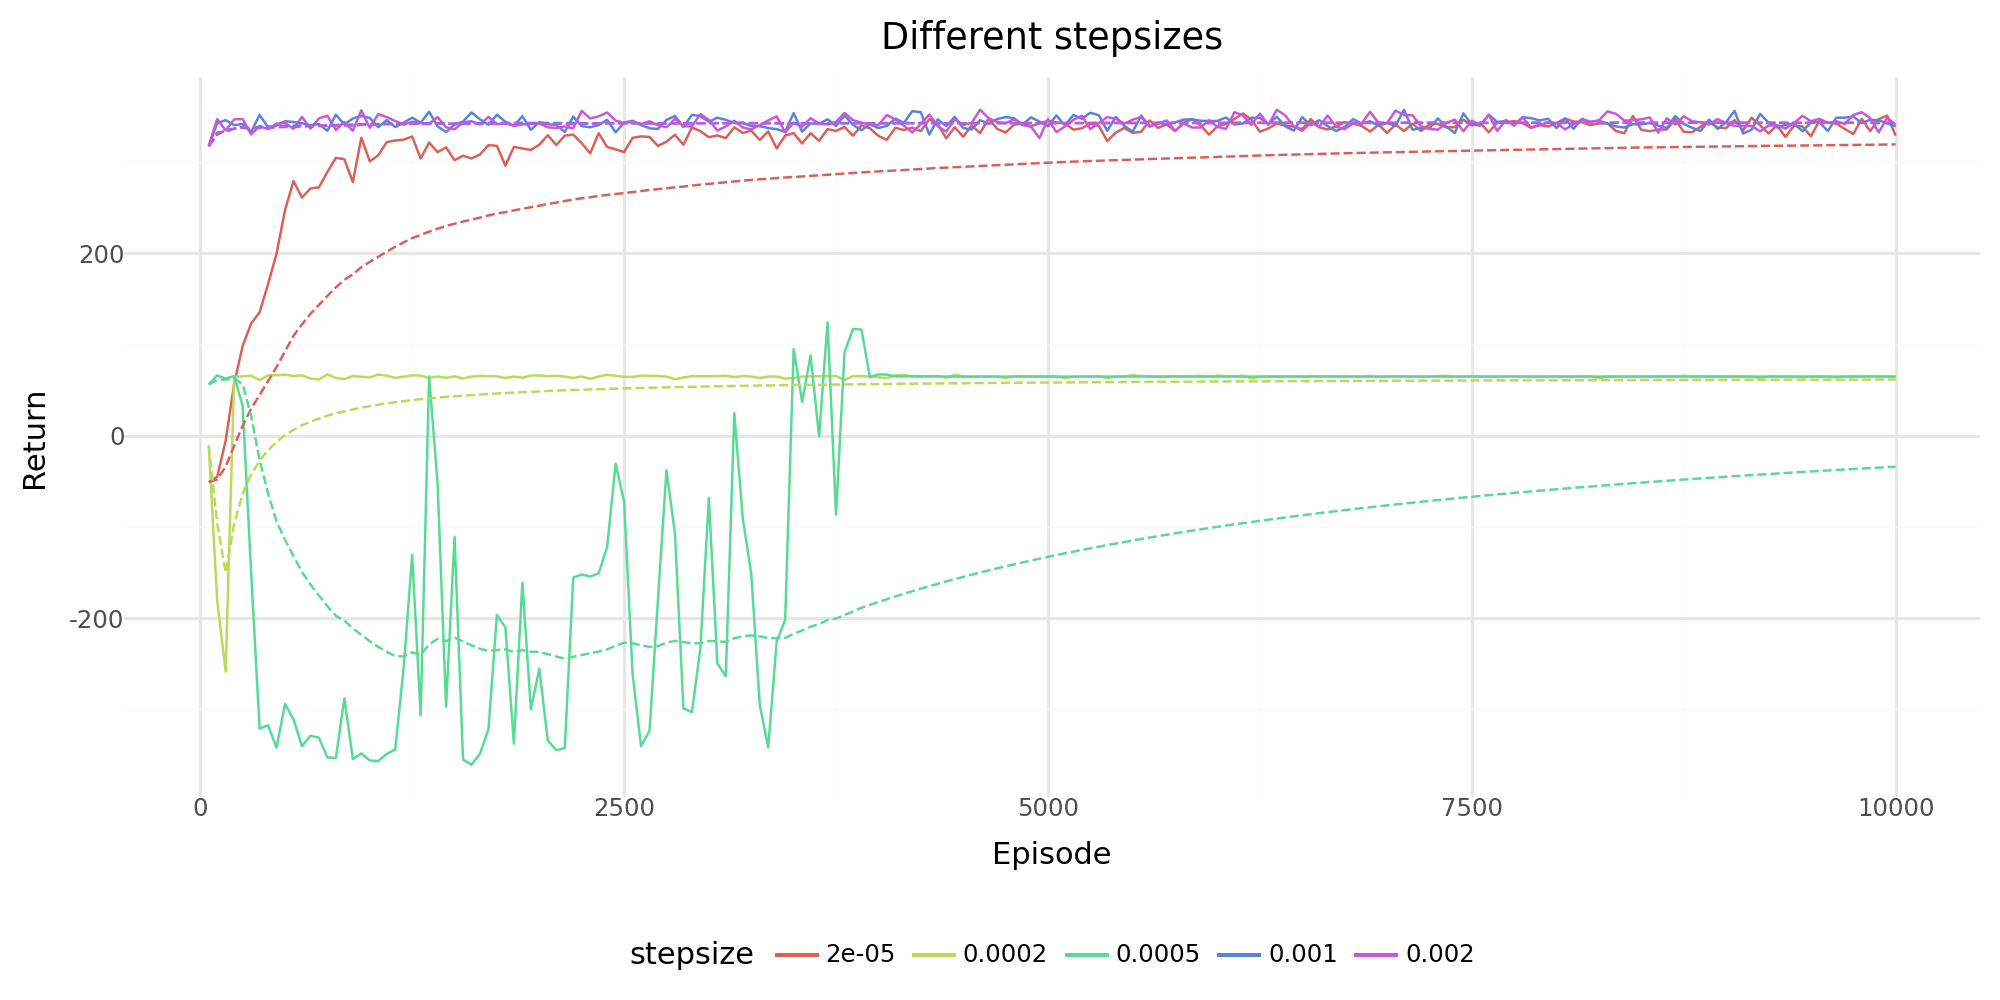

In [ ]:
def sweep_stepsizes(
    env,
    stepsizes,
    algorithm,
    gamma=gamma,
    episodes=episodes,
    rng_seed=42,
):
    results = []
    for alpha in stepsizes:
        print(f"\n=== Testing step-size α = {alpha} ===")

        # Fresh policy for each alpha
        pi_hat = SoftmaxPolicy(
            env=env,
            step_size=alpha,
            decay_fct=1.0,
            rng_seed=rng_seed,
        )
        def cb(policy, info, trace_list):
            trace_list.append({
                "stepsize": alpha,
                "episode": info["episode"],
                "avg_return": info["avg_return"],
                "avg_return_every": info["avg_return_every"],
            })
        trace = []
        algorithm(
            pi_hat=pi_hat,
            episodes=episodes,
            gamma=gamma,
            callback=cb,
            callback_every=50,
            trace=trace,
        )
        results.extend(trace)
    dat_r = pd.DataFrame(results)
    dat_r['stepsize'] = pd.Categorical(dat_r['stepsize'])
    pt = (
        dat_r
        >> ggplot(aes(x = "episode", y = "avg_return_every", color = "stepsize"))
        + geom_line()
        + geom_line(aes(y = "avg_return"), linetype = "dashed")
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title="Different stepsizes",
            x="Episode",
            y="Return",
        )
    )
    pt.show()

env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=42
)

stepsizes = [2e-5, 2e-4, 5e-4, 1e-3, 2e-3]
sweep_stepsizes(
    env=env,
    stepsizes=stepsizes,
    algorithm=reinforce,
)

### Your turn

Comment on the results.

## REINFORCE with baseline

We are now ready to implement REINFORCE

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1304_REINFORCE_With_Baseline.png)

First, consider this implementation.

In [ ]:
#@title Reinforce w average baseline

def reinforce_w_avg_baseline(
    pi_hat,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Runs the REINFORCE algorithm with a given policy, using a scalar baseline.

    This uses the episodic, discounted REINFORCE algorithm as in Sutton &
    Barto (2nd ed.), with the update:

        θ ← θ + α * (γ^t) * (G_t - b) * ∇θ log π(A_t | S_t; θ),

    where G_t is the discounted return from time t and b is a baseline that
    does not depend on the action (here: running average of past episode returns).

    Args:
        pi_hat: Policy object implementing get_action() and train().
        episodes: Number of episodes to run.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
            Signature: callback(pi_hat, info, trace).
        callback_every: Frequency of callback in episodes. If 0, callback
            is never called.
        trace: Optional object passed through to callback (e.g., list or
            dict for logging).
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generates one episode using the current policy.

        Args:
            policy: Policy used to generate actions.

        Returns:
            A list of (s, a, r) tuples for one episode.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0
    baseline = 0.0  # running average of past episode returns

    for ep in tqdm(range(1, episodes + 1)):
        trajectory = generate_episode(pi_hat)

        # Compute returns G_t backward and update policy
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t

            # Baseline REINFORCE: (G_t - b)
            advantage_t = G_t - baseline
            mult = (gamma ** t) * advantage_t

            pi_hat.train(s_t, a_t, mult)

        # At the end of the backward pass, G_t is the return from t=0
        episode_return = G_t
        total_return += episode_return
        total_return_every += episode_return
        baseline = total_return / ep

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "diff_return": advantage_t,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


### Your turn

Which baseline is used?

*Your comments*

100%|██████████| 10000/10000 [00:22<00:00, 435.59it/s]


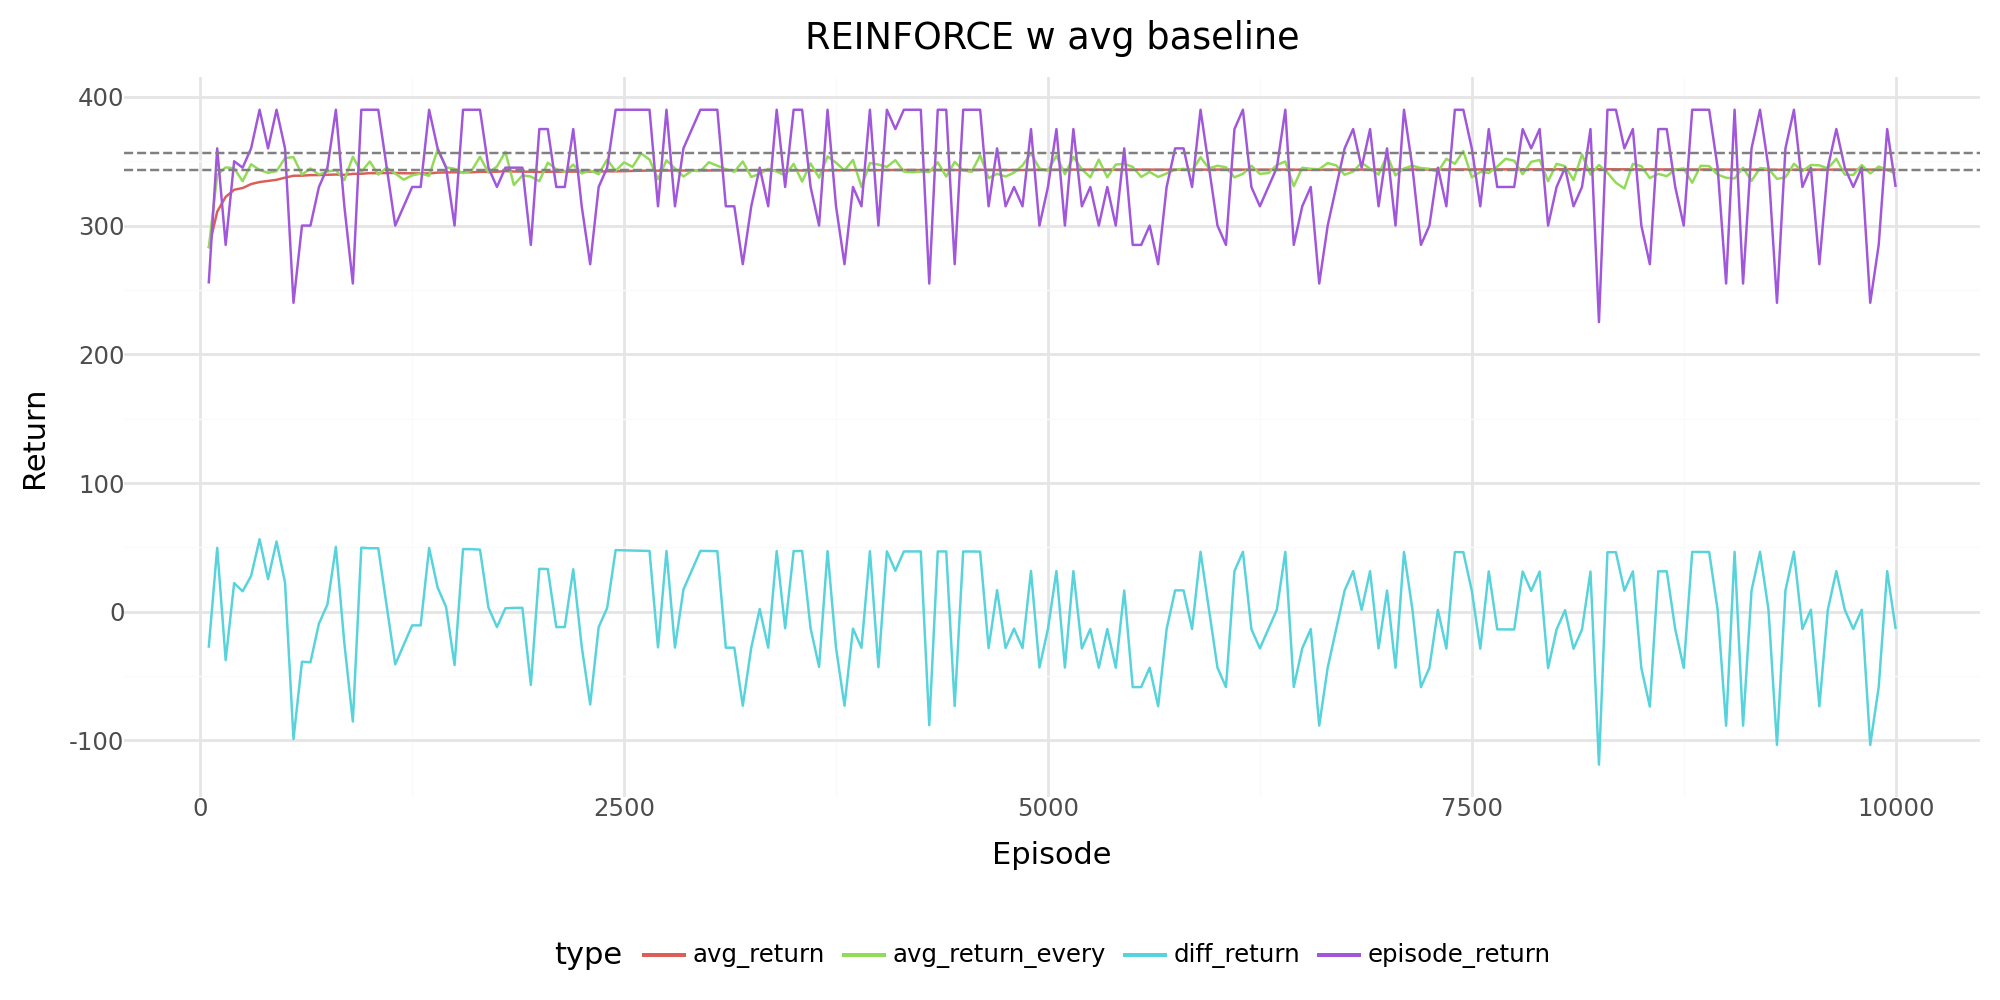

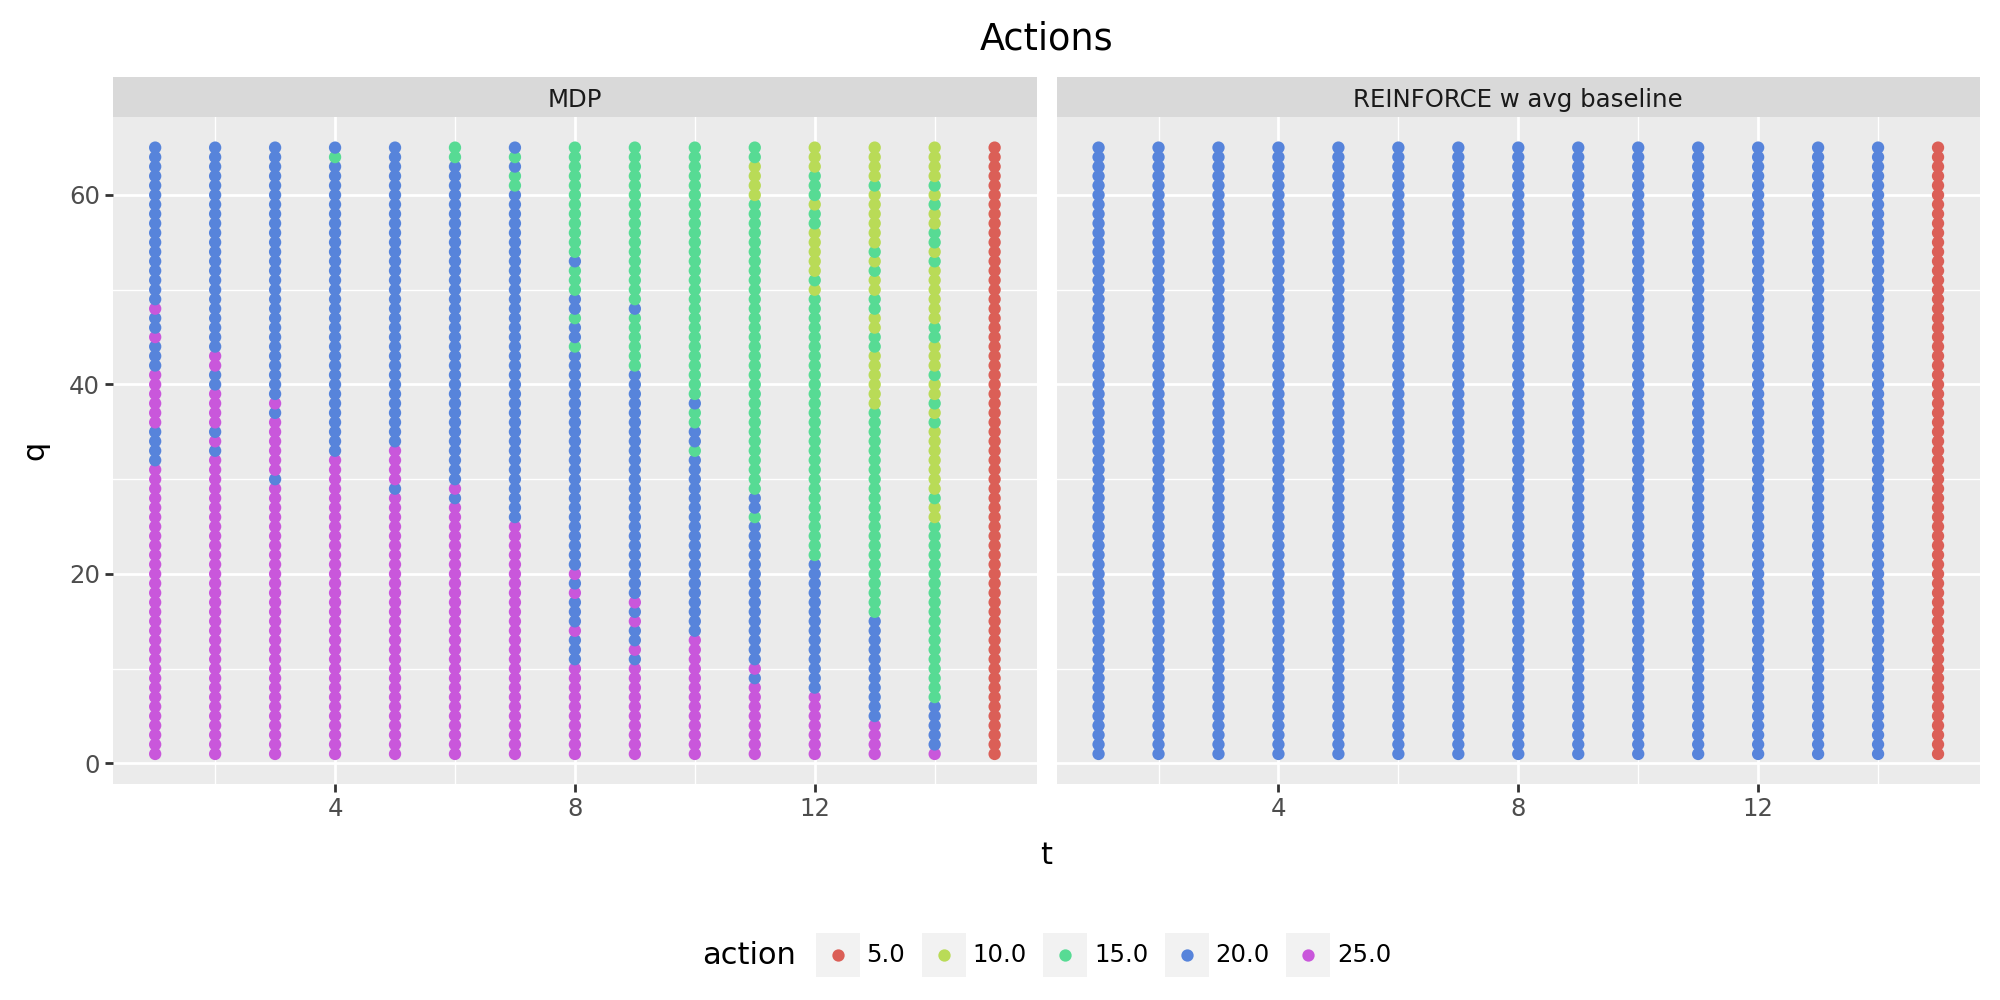

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=1e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# Run REINFORCE w baseline
trace_re_bl = []   # will hold dicts: {episode, avg_return}
reinforce_w_avg_baseline(
    pi_hat=pi_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re_bl
)
plot_results(pi_hat, trace_re_bl, dat_mdp, title_r = "REINFORCE w avg baseline")

### Your turn

Why will this reduce variance in updates?

*Your comments*

A state-value baseline can also be used. Let us define a state-value linear approximation.

In [ ]:
class ValueFunction:
    """
    Quadratic (degree-2) polynomial state-value function:

        v(s) = wᵀ x(s)

    with features:
        x(s) = [1,
                q_norm,
                t_norm,
                q_norm^2,
                t_norm^2,
                q_norm * t_norm]
    """

    def __init__(self, env, step_size: float) -> None:
        """
        Initialize the approximator.

        Parameters
        ----------
        env : Environment
            Must have attributes max_inv and max_t.
        step_size : float
            Learning rate for the critic.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        self.alpha_v = float(step_size)

        # 1 + 2 + 3 = 6 polynomial features
        self.w = np.zeros(6, dtype=float)

    def get_features(self, s: Sequence[int]) -> np.ndarray:
        """
        Construct polynomial degree-2 features for state s = [q, t].
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        return np.array(
            [
                1.0,        # bias
                qn,         # q
                tn,         # t
                qn * qn,    # q^2
                tn * tn,    # t^2
                qn * tn     # q t
            ],
            dtype=float
        )

    def eval(self, s: Sequence[int]) -> float:
        """Estimate v(s)."""
        x_s = self.get_features(s)
        return float(np.dot(self.w, x_s))

    def train(self, s: Sequence[int], target: float) -> None:
        """
        Semi-gradient Monte Carlo update:

            w <- w + alpha * (target - v(s)) * x(s)
        """
        x_s = self.get_features(s)
        v_hat = float(np.dot(self.w, x_s))
        delta = target - v_hat
        self.w += self.alpha_v * delta * x_s


In [ ]:
#@title Reinforce w value baseline

def reinforce_w_value_baseline(
    pi_hat,
    v_hat,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """REINFORCE with a state-dependent baseline v_hat(s).

    Actor update:
        θ ← θ + α_θ * (γ^t) * (G_t - v_hat(s_t)) * ∇θ log π(a_t | s_t; θ)

    Critic update (Monte Carlo):
        w ← w + α_v * (G_t - v_hat(s_t)) ∇_w v_hat(s_t)

    Args:
        pi_hat: Policy approximator (actor).
        v_hat: State-value approximator (critic / baseline).
        episodes: Number of episodes.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
        callback_every: Frequency of callback in episodes; 0 disables callback.
        trace: Optional object passed to callback for logging.
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generate one episode using the current policy.

        Returns:
            List of (s, a, r) tuples.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0

    for ep in range(1, episodes + 1):
        trajectory = generate_episode(pi_hat)

        # Backward pass: compute G_t and update actor + critic
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t

            # Baseline: state-dependent value estimate
            b_t = v_hat.eval(s_t)
            advantage_t = G_t - b_t

            # Actor update multiplier corresponds to γ^t * advantage_t
            mult = (gamma ** t) * advantage_t
            pi_hat.train(s_t, a_t, mult)

            # Critic update toward Monte Carlo target G_t
            v_hat.train(s_t, G_t)

        episode_return = G_t  # return from t=0 after loop
        total_return += episode_return
        total_return_every += episode_return

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "diff_return": advantage_t,
                "approx return (v(s))": b_t,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


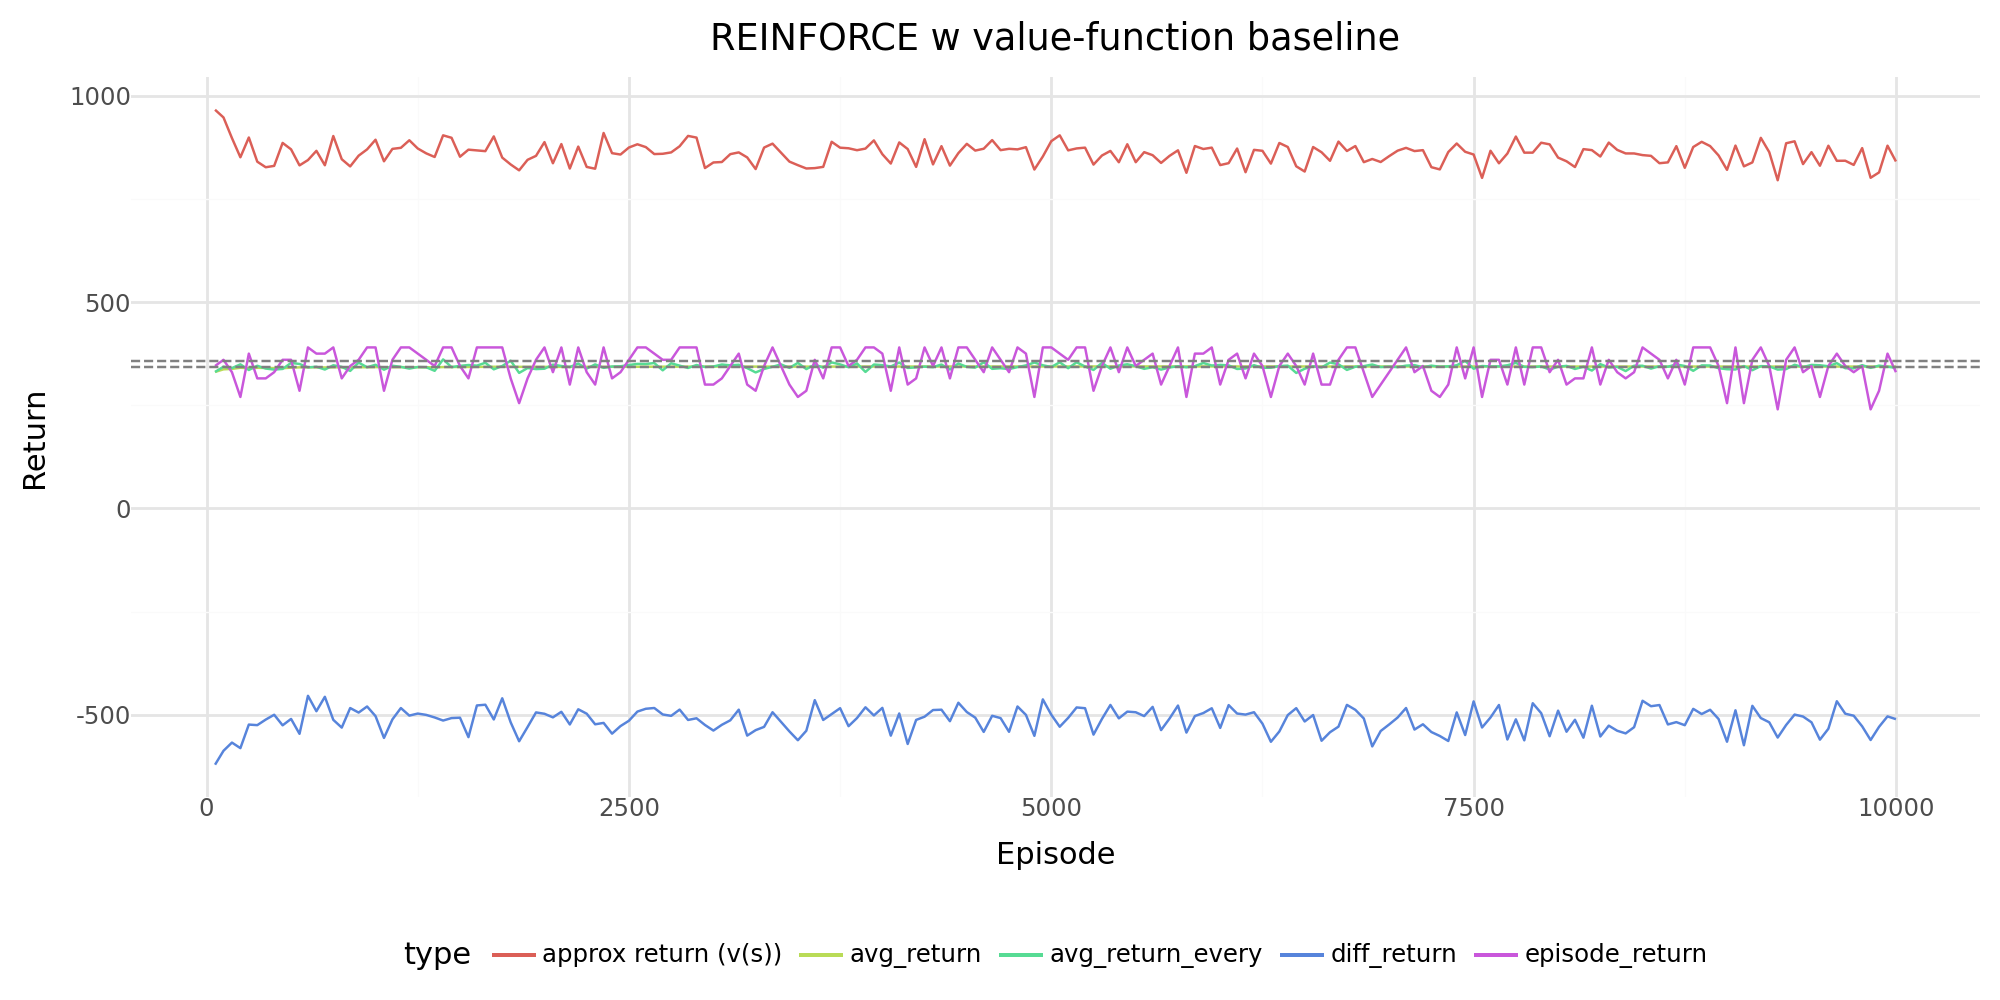

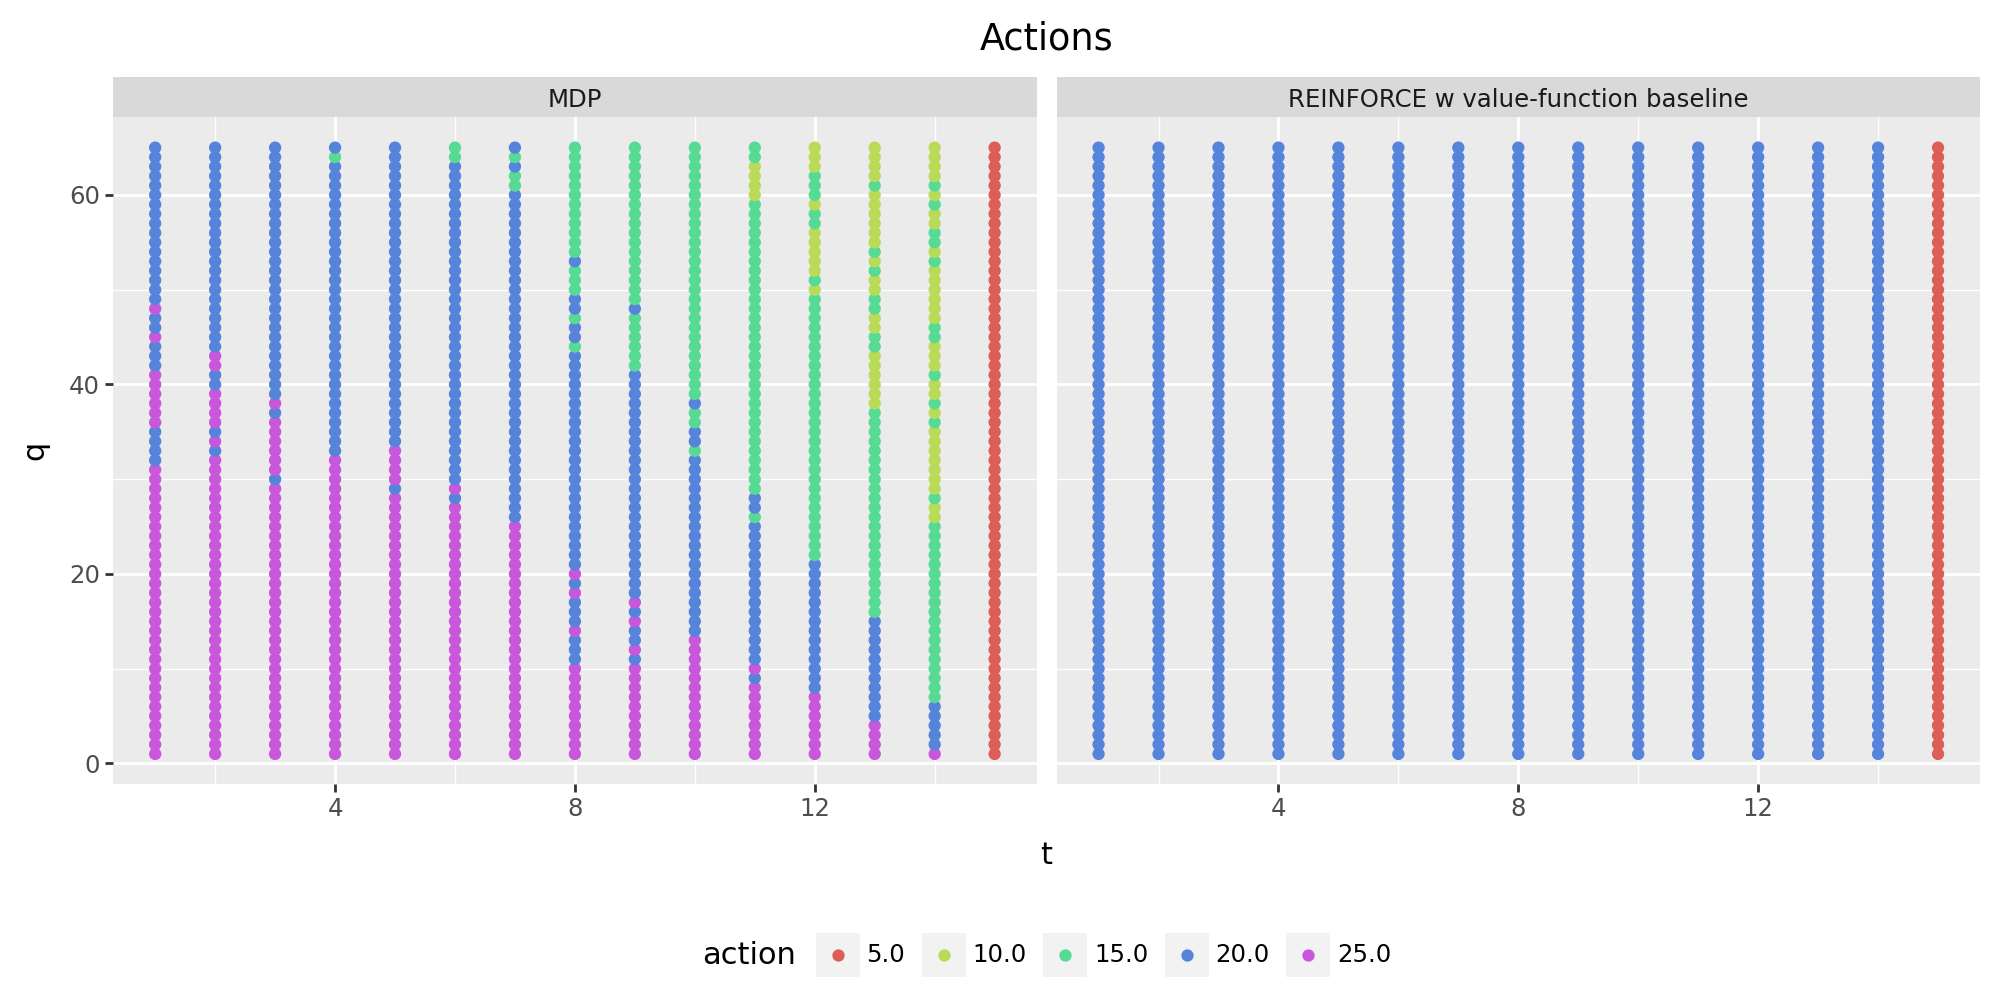

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=2e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# value function (critic / baseline)
v_hat = ValueFunction(
    env=env,
    step_size=5e-2,   # often a bit larger than actor step size
)

# Run REINFORCE w baseline
trace_re_v_bl = []   # will hold dicts: {episode, avg_return}
reinforce_w_value_baseline(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re_v_bl
)
plot_results(pi_hat, trace_re_v_bl, dat_mdp, title_r = "REINFORCE w value-function baseline")

### Your turn

Describe the output.

*Your comments*



## Actor Critic

Let us inplement the actor critic algorithm

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1305a_One_Step_Actor_Critic.png)



In [ ]:
#@title Actor-critic algorithm

def actor_critic(
    pi_hat: SoftmaxPolicy,
    v_hat,  # e.g. ValueFunctionPoly2
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """One-step (TD(0)) actor–critic with discount factor I (γ^t) as in the first
    boxed algorithm in the actor–critic section.

    Critic (TD(0)):
        δ_t = R_{t+1} + γ v_hat(S_{t+1}) - v_hat(S_t)
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ I δ_t ∇_θ log π(A_t | S_t)
        I ← γ I

    where I starts at 1 at the beginning of each episode.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with value(s) and update(s, target).
        episodes: Number of episodes.
        gamma: Discount factor γ.
        callback: Optional logging callback.
        callback_every: Callback frequency (episodes).
        trace: Passed through to callback.
    """

    total_return = 0.0
    total_return_every = 0.0

    for ep in tqdm(range(1, episodes + 1)):
        s = pi_hat.env.reset()
        done = False

        I = 1.0  # discount factor I = γ^t
        G_episode = 0.0
        t = 0

        while not done:
            # Sample action from current policy
            a = pi_hat.get_action(s)

            # Environment step
            s_next, r, done = pi_hat.env.get_step(s, a)

            # Critic: TD target and error
            v_s = v_hat.eval(s)
            v_s_next = 0.0 if done else v_hat.eval(s_next)
            td_target = r + gamma * v_s_next
            delta_t = td_target - v_s

            # Actor: update with I * δ_t
            mult = I * delta_t
            pi_hat.train(s, a, mult)

            # Critic: update toward td_target (semi-gradient TD(0))
            v_hat.train(s, td_target)

            # Update discount factor and bookkeeping
            G_episode += I * r
            I *= gamma       # I = γ^(t+1)
            s = s_next
            t += 1

        total_return += G_episode
        total_return_every += G_episode

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "episode_return": G_episode,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every,
                "approx_return": v_hat.eval(pi_hat.env.reset())
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


100%|██████████| 10000/10000 [00:27<00:00, 357.99it/s]


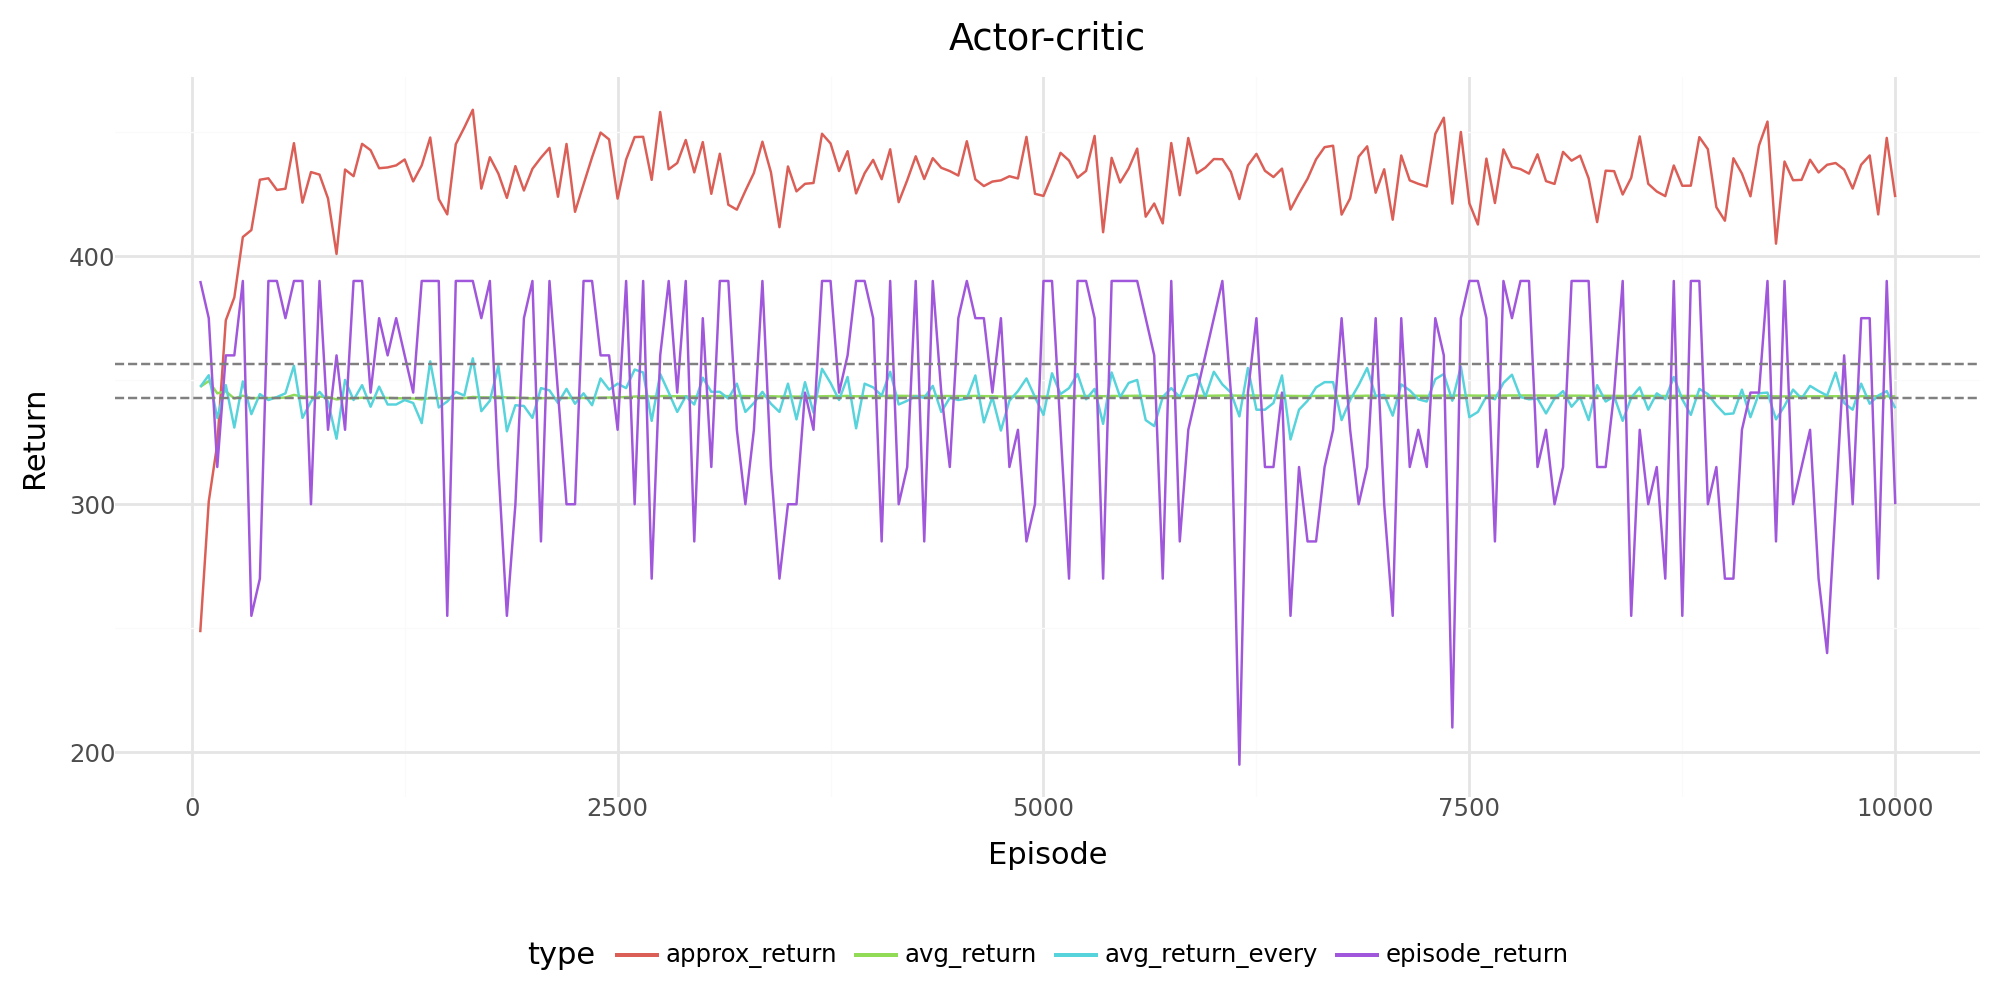

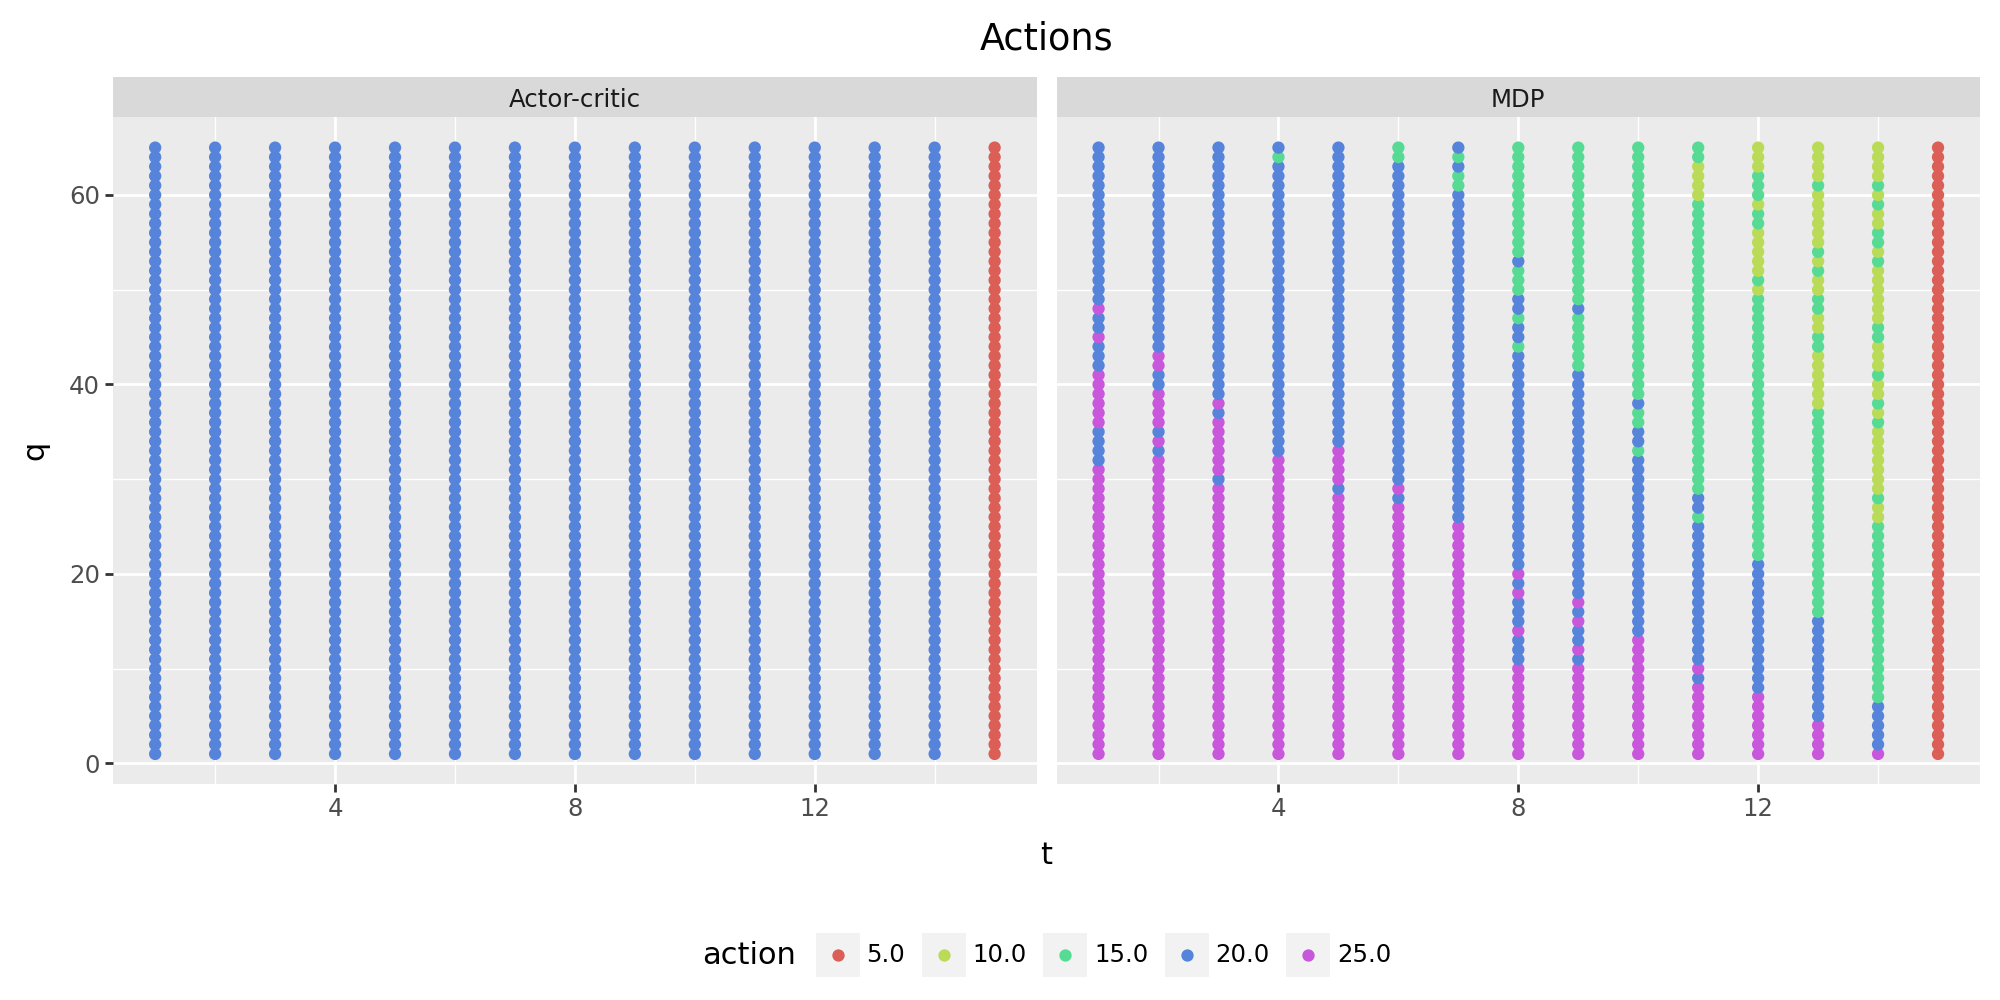

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=0.01,
    decay_fct=1.0,
    rng_seed=42,
)

# value function (critic / baseline)
v_hat = ValueFunction(
    env=env,
    step_size=0.05,   # often a bit larger than actor step size
)

# Run REINFORCE w baseline
trace_ac = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac
)
plot_results(pi_hat, trace_ac, dat_mdp, title_r = "Actor-critic")

### Your turn

Explain the output.

*Your comments*

## Comparison - All algorithms

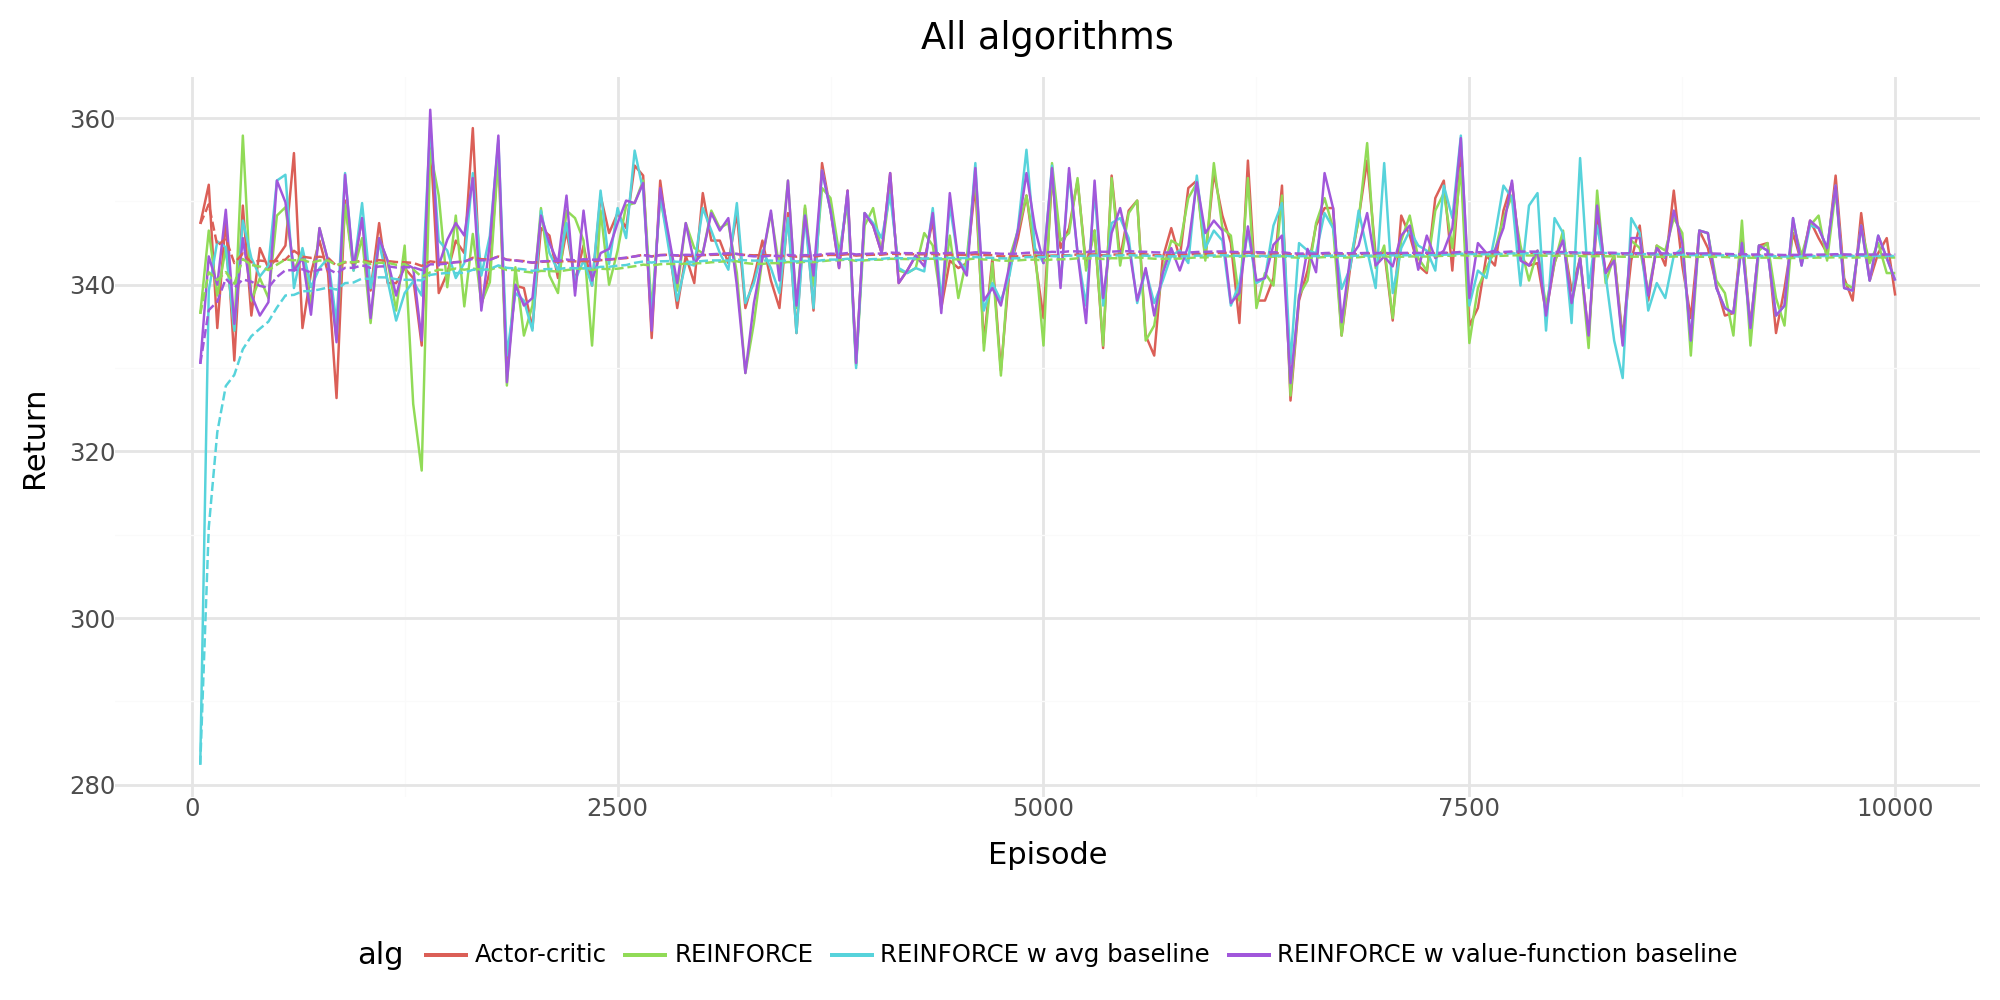

In [ ]:
dat_r = pd.DataFrame()
dat = pd.DataFrame(trace_re) >> mutate(alg = "REINFORCE")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_re_bl) >> mutate(alg = "REINFORCE w avg baseline")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_re_v_bl) >> mutate(alg = "REINFORCE w value-function baseline")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_ac) >> mutate(alg = "Actor-critic")
dat_r = pd.concat([dat_r, dat], ignore_index=True)

pt = (
    dat_r
    >> ggplot(aes(x = "episode", y = "avg_return_every", color = "alg"))
    + geom_line()
    + geom_line(aes(y = "avg_return"), linetype = "dashed")
    + theme_minimal()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(
        title="All algorithms",
        x="Episode",
        y="Return",
    )
)
pt.show()

## Other approximations

Other state-value and policy approximations can be used. Here we define a few and test.

In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyTabular:
    """
    Softmax policy with a separate parameter for each (state, action) pair.

    For each action a and state s, there is a scalar weight θ[a, idx(s)].
    The preference function is:

        h(s, a) = θ[a, idx(s)]

    where idx(s) is a unique integer index for the state s = [q, t].
    Effectively, this corresponds to a one-hot state feature vector.
    """

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Initialize the tabular softmax policy.

        Args:
            env: Environment providing attributes `max_inv`, `max_t`,
                 `prices`, `scrap_price`, and method `get_actions(s)`.
            step_size: Initial learning rate α.
            decay_fct: Multiplicative decay applied to α after each update.
            rng_seed: Optional random seed.
        """
        self.env = env
        self.max_inv: int = env.max_inv
        self.max_t: int = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions: int = len(self.all_actions)

        # Number of non-terminal states: q = 1..max_inv, t = 1..max_t
        self.num_states: int = self.max_inv * self.max_t

        # Learning rate
        self.initial_alpha: float = float(step_size)
        self.alpha: float = float(step_size)
        self.decay_fct: float = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Parameter matrix θ: shape (num_actions, num_states)
        self.theta: np.ndarray = np.zeros(
            (self.num_actions, self.num_states),
            dtype=float,
        )

        # Optional: logit clipping range (helps stability)
        self.logit_min = -20.0
        self.logit_max = 20.0

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # State indexing (one-hot over states)
    # ------------------------------------------------------------------

    def _state_index(self, s: Sequence[int]) -> int:
        """
        Map state s = [q, t] to a unique integer index in [0, num_states-1].

        We use row-major order: idx = (q-1) * max_t + (t-1).
        """
        q, t = s
        # assume 1 <= q <= max_inv, 1 <= t <= max_t for non-terminal states
        return (q - 1) * self.max_t + (t - 1)

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        state_idx = self._state_index(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        prefs = np.array([self.theta[i, state_idx] for i in idxs], dtype=float)
        return prefs

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        # Clip logits to avoid extreme saturation
        prefs = np.clip(prefs, self.logit_min, self.logit_max)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """
        Computes ∇_θ log π(a | s).

        Since h(s, a) = θ[a, idx(s)], the gradient is non-zero only in
        the column corresponding to idx(s). For actions among the
        available set:

            ∂/∂θ[a,s] log π(a|s)     = 1 - π(a|s)
            ∂/∂θ[b,s] log π(a|s)     = -π(b|s),  b ≠ a

        All other (action, state') entries are zero.
        """
        state_idx = self._state_index(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi, state_idx] = 1.0 - p
            else:
                grad[gi, state_idx] = -p

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """
        θ ← θ + α * mult * ∇_θ log π(a | s).

        Args:
            s: State at time t.
            a: Action taken at time t.
            mult: Scalar multiplier (e.g., (γ^t) G_t or δ_t).
        """
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence


class ValueFunctionFourier:
    """
    State-value function approximator with 2D Fourier basis.

    v(s; w) = wᵀ x(s),

    where x(s) are Fourier features over normalized (q, t):

        q_norm = q / max_inv
        t_norm = t / max_t

        x_k(s) = cos( 2π (c1 * q_norm + c2 * t_norm) )

    for all integer pairs (c1, c2) with 0 <= c1, c2 <= fourier_order.
    """

    def __init__(self, env, step_size: float, fourier_order: int = 3) -> None:
        """
        Initialize the Fourier value function.

        Parameters
        ----------
        env : object
            Environment with attributes `max_inv` and `max_t`.
        step_size : float
            Learning rate α_v for the critic.
        fourier_order : int, optional
            Fourier order n. Number of features is (n+1)^2. Default is 3.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        self.alpha_v = float(step_size)
        self.n = int(fourier_order)

        # Coefficient pairs (c1, c2), c1,c2 = 0..n
        self.coeffs = np.array(
            [(i, j) for i in range(self.n + 1)
                    for j in range(self.n + 1)],
            dtype=float,
        )
        self.num_features = (self.n + 1) ** 2

        # Parameter vector w
        self.w = np.zeros(self.num_features, dtype=float)

    def get_features(self, s: Sequence[int]) -> np.ndarray:
        """
        Compute Fourier feature vector x(s) for state s = [q, t].

        Returns
        -------
        np.ndarray
            Feature vector with length num_features.
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        z = 2.0 * np.pi * (self.coeffs[:, 0] * qn + self.coeffs[:, 1] * tn)
        return np.cos(z)

    def eval(self, s: Sequence[int]) -> float:
        """
        Estimate v(s).

        Parameters
        ----------
        s : Sequence[int]
            State [q, t].

        Returns
        -------
        float
            Estimated value v_hat(s).
        """
        x_s = self.get_features(s)
        return float(np.dot(self.w, x_s))

    def train(self, s: Sequence[int], target: float) -> None:
        """
        Semi-gradient update toward a target (MC or TD):

            δ = target - v(s)
            w ← w + α_v * δ * x(s)

        Parameters
        ----------
        s : Sequence[int]
            State being updated.
        target : float
            Target value for v(s), e.g. G_t (MC) or r + γ v(s').
        """
        x_s = self.get_features(s)
        v_hat = float(np.dot(self.w, x_s))
        delta = target - v_hat
        self.w += self.alpha_v * delta * x_s


100%|██████████| 5000/5000 [00:07<00:00, 691.08it/s]


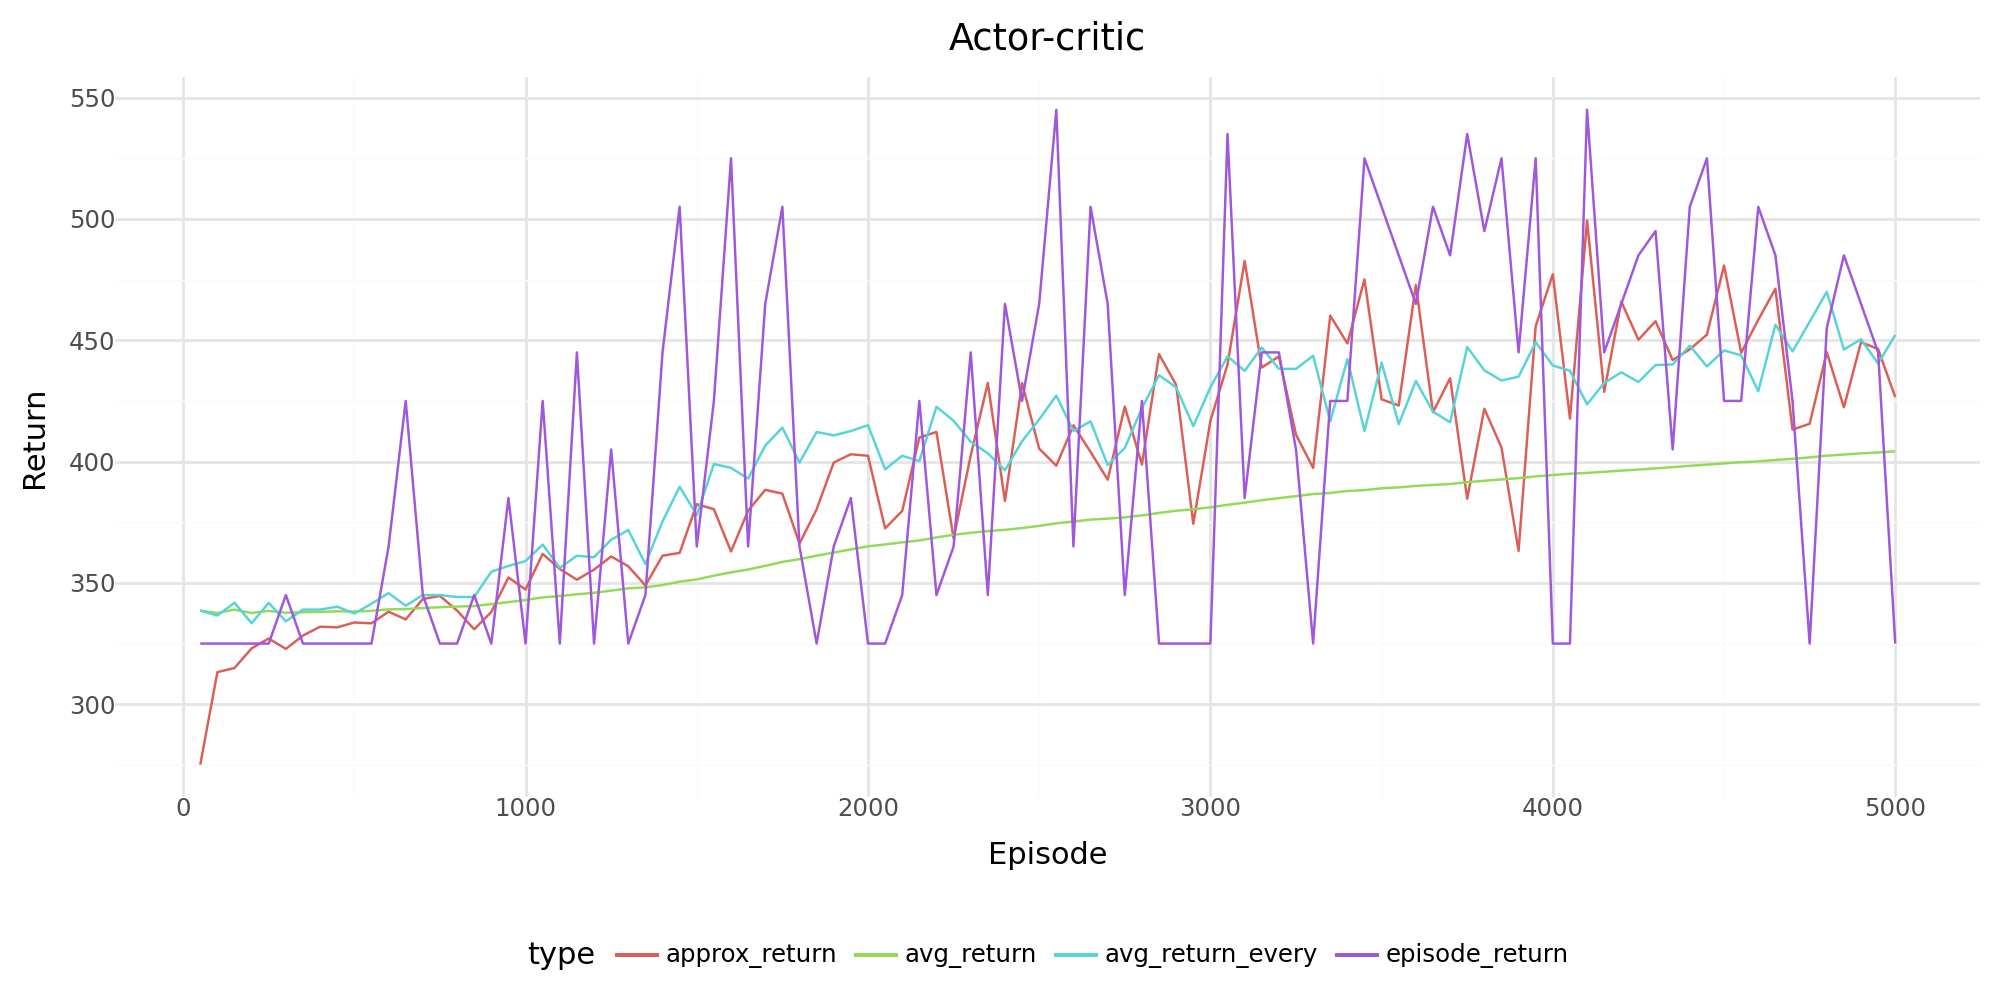

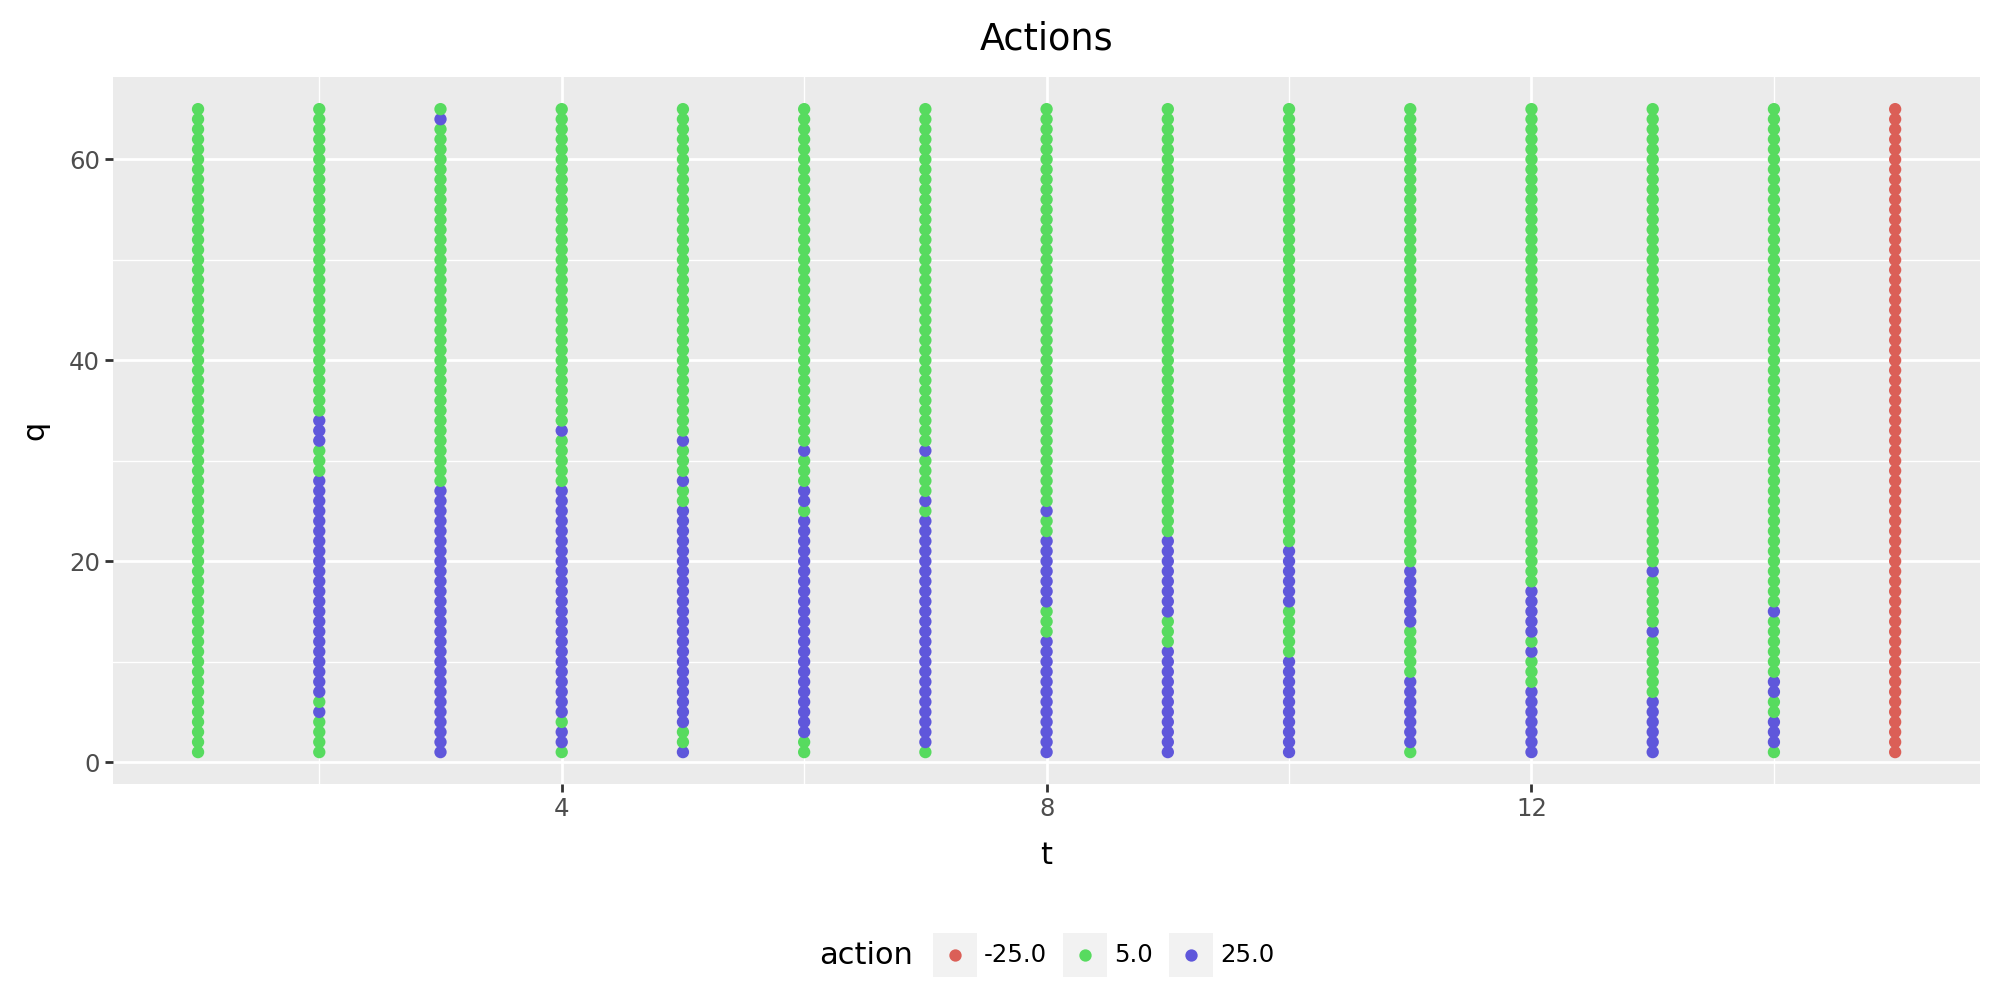

100%|██████████| 5000/5000 [00:09<00:00, 522.02it/s]


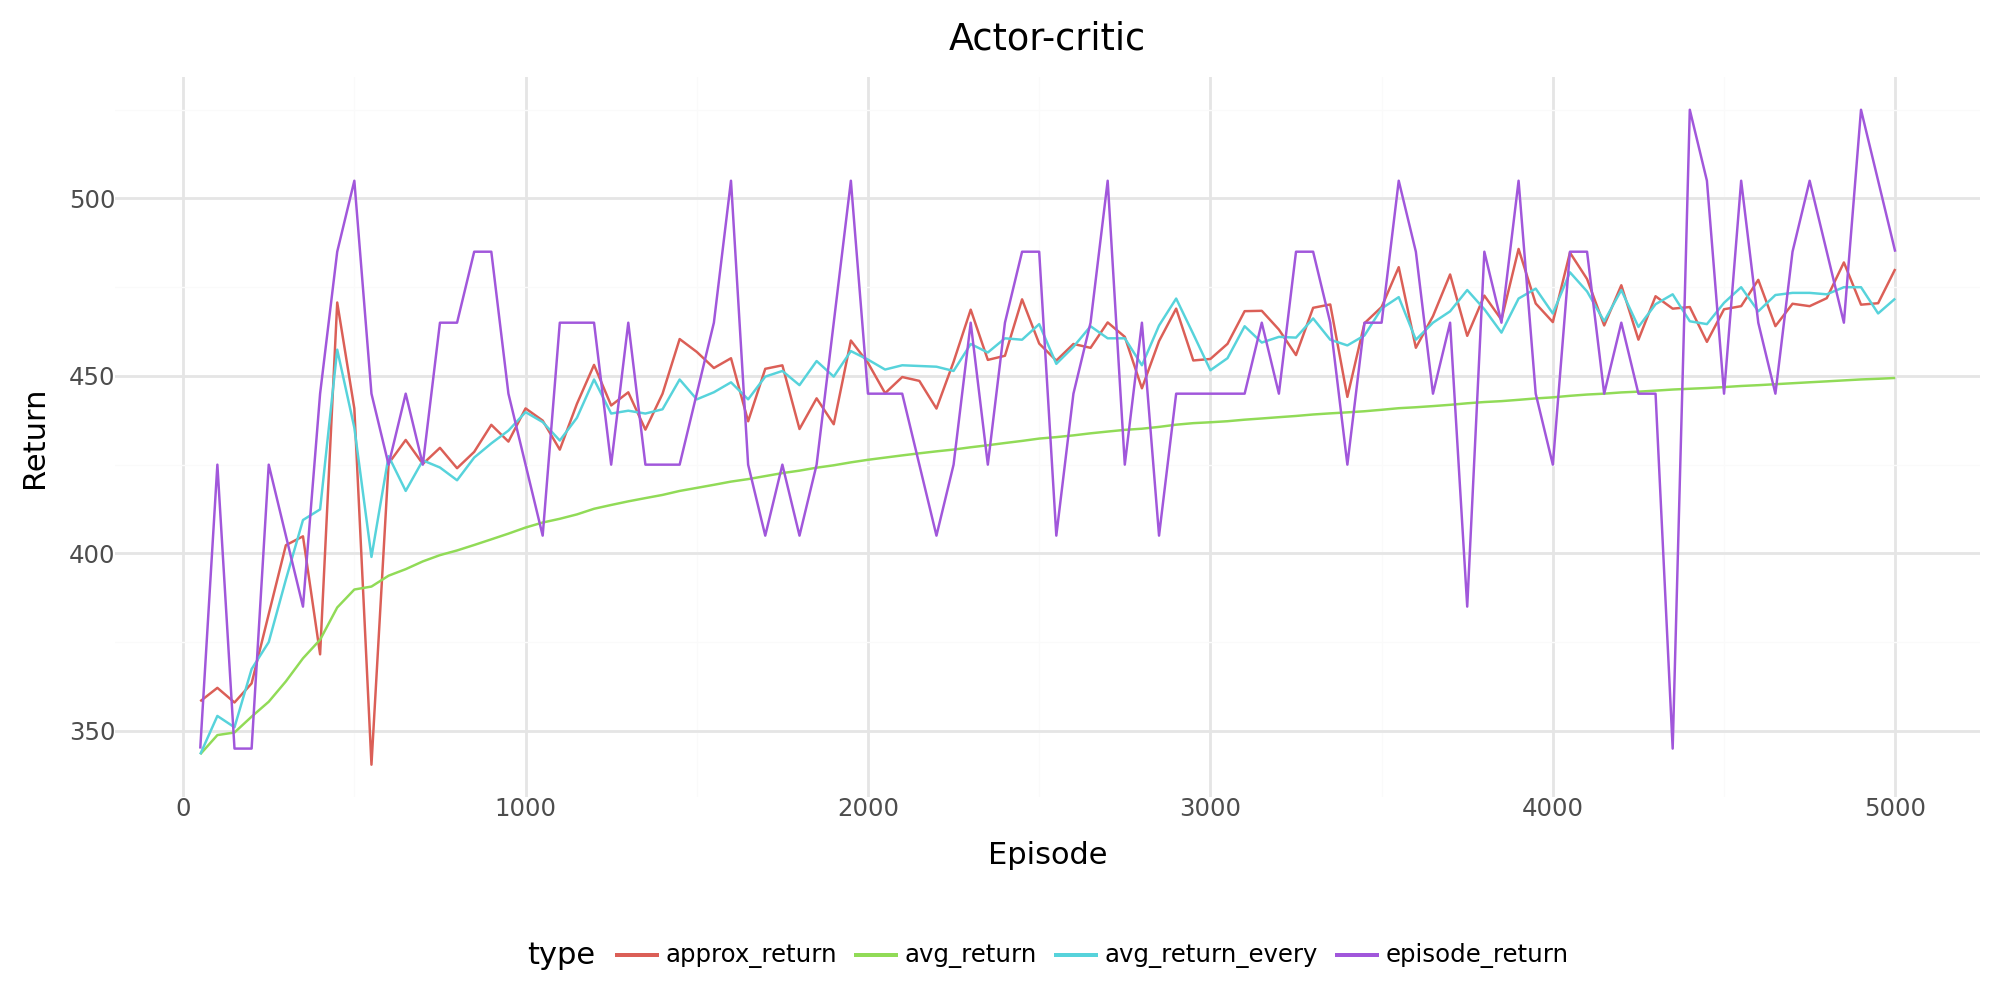

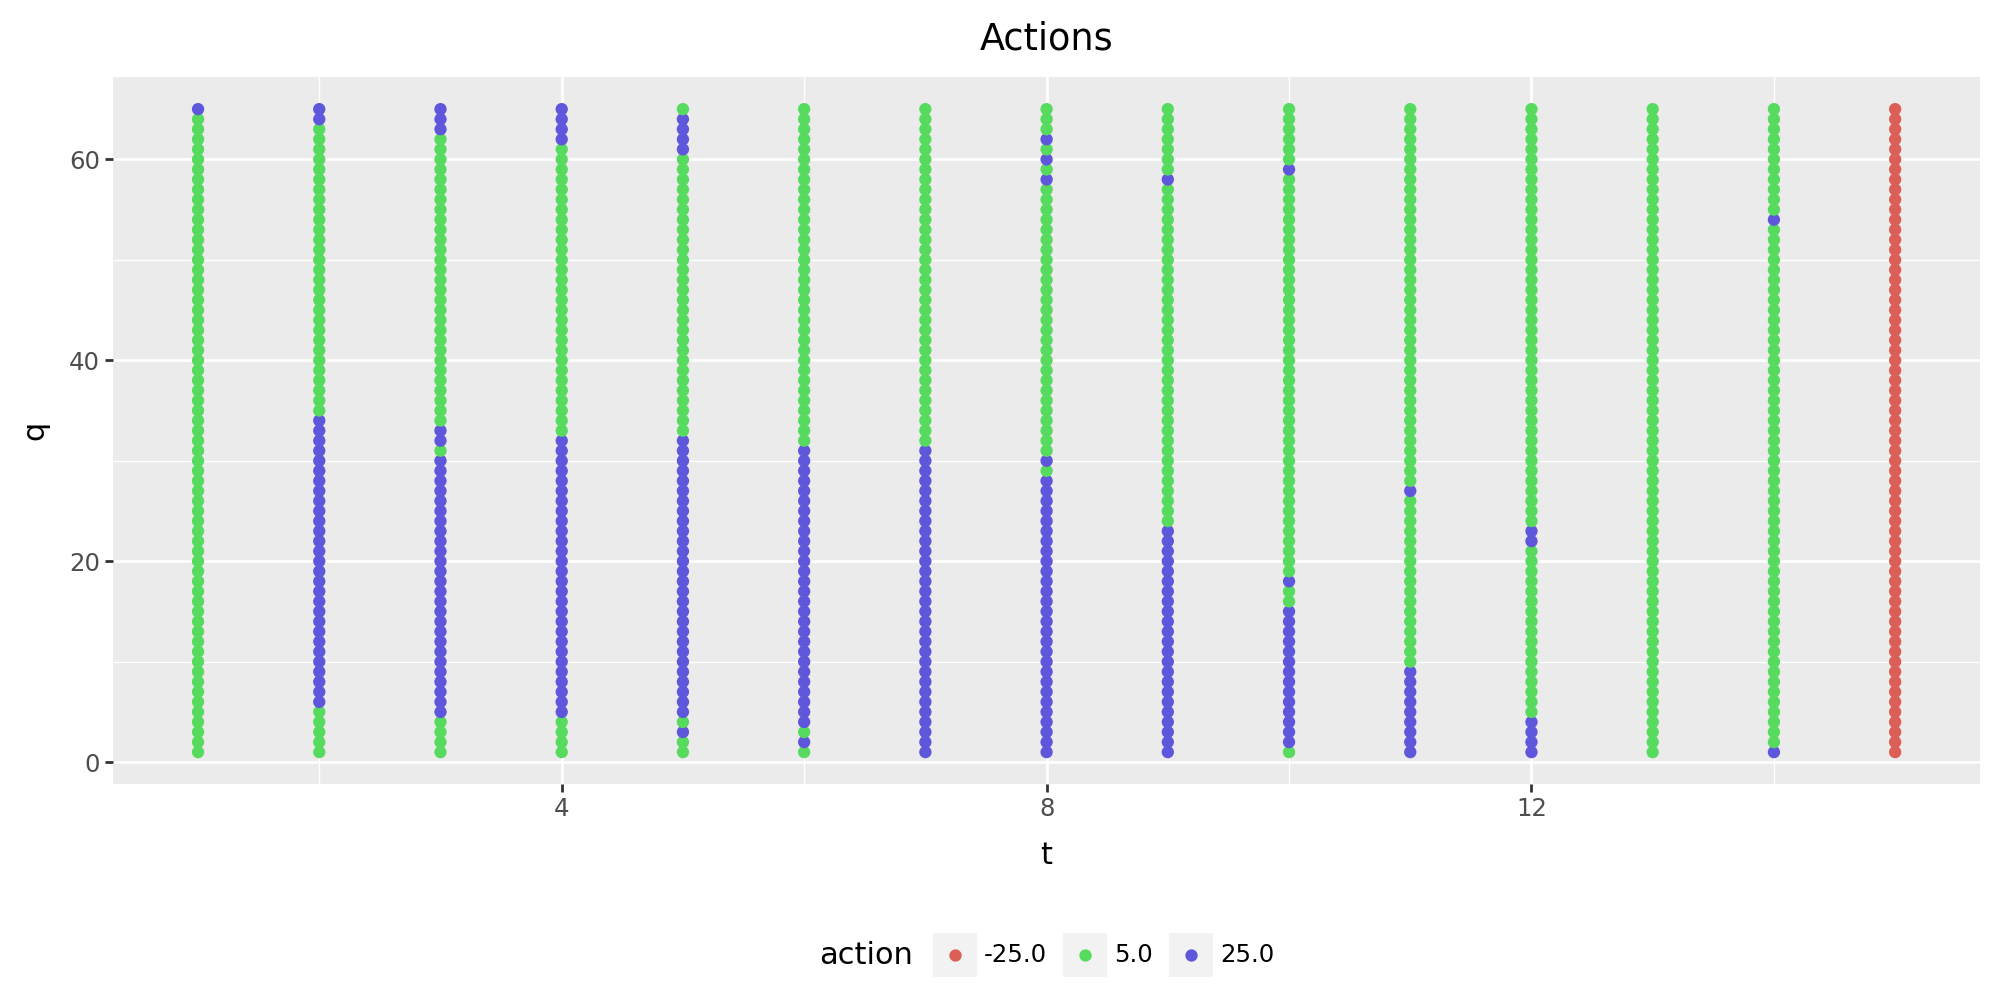

In [ ]:
#@title Testing using another environment

# Define candidate sales prices
prices = [5, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=-25.0,
    purchase_price=0,
    prices=prices,
    start_q=65,
    seed=876
)


# Run 1
# Create the policy
pi_hat = SoftmaxPolicyTabular(
    env=env,
    step_size=0.01,
    decay_fct=1,
    rng_seed=42
)

# value function
v_hat = ValueFunctionFourier(
    env=env,
    step_size=5e-3,   # often a bit larger than actor step size
    fourier_order=5
)

trace_ac1 = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=5000,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac1
)
plot_results(pi_hat, trace_ac1, dat_mdp, title_r = "Actor-critic", plot_hlines=False, plot_policy=True, plot_mdp=False)


# Run 2
pi_hat = SoftmaxPolicyTabular(
    env=env,
    step_size=0.01,
    decay_fct=1,
    rng_seed=42
)

v_hat = ValueFunction(
    env=env,
    step_size=0.05,   # often a bit larger than actor step size
)

trace_ac2 = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=5000,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac2
)
plot_results(pi_hat, trace_ac2, dat_mdp, title_r = "Actor-critic", plot_hlines=False, plot_policy=True, plot_mdp=False)


### Your turn

Comment on the results.

*Your comments*

# Exercises

### Exercise (seasonal inventory)

Consider the seasonal inventory and sales planning problem using the environment:

```
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=25.0,
    purchase_price=0,
    prices=[5, 25],
    start_q=65,
    seed=876
)
```

1. How do you expect the optimal policy to look? Solve the problem.

Now change the enviroment to

```
env = RLEnvSeasonal(
    max_inv=10,
    max_t=15,
    scrap_price=-25.0,
    purchase_price=0,
    prices=[5, 25],
    start_q=10,
    seed=876
)
```

2. How do you expect the optimal policy to look? Solve the problem.